# Prétraitement des données textuelles


In [105]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ast  # Pour convertir les chaînes JSON-like en dictionnaires
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud



In [ ]:
# Télécharger les stopwords et outils si non disponibles
nltk.download("stopwords", quiet=True)

def load_data(file_path):
    """
    Charger les données à partir d'un fichier CSV.

    :param file_path: Chemin vers le fichier CSV
    :return: DataFrame pandas contenant les données
    """
    data = pd.read_csv(file_path)
    return data

def clean_text(text):
    """
    Nettoyer le texte en supprimant les caractères inutiles et en le normalisant.

    :param text: Texte brut
    :return: Texte nettoyé
    """
    if pd.isnull(text):
        return ""
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Supprimer les caractères spéciaux
    text = text.lower()  # Passer en minuscules
    text = re.sub(r"\s+", " ", text).strip()  # Supprimer les espaces multiples
    return text

def extract_product_specifications(data):
    """
    Crée des DataFrames par catA à partir des spécifications des produits.

    :param data: DataFrame original contenant la colonne product_specifications
    :return: Dictionnaire de DataFrames (un par catA)
    """
    # Initialiser un dictionnaire pour les DataFrames par catégorie catA
    category_dfs = {}

    # Parcourir les catégories uniques dans catA
    for category in data["catA"].unique():
        if pd.isnull(category):  # Ignorer les catégories nulles
            continue

        # Filtrer les produits pour cette catégorie
        category_data = data[data["catA"] == category]

        # Extraire les spécifications sous forme de colonnes
        specifications = []
        for index, row in category_data.iterrows():
            if isinstance(row["product_specifications"], str):
                # Remplacer '=>' par ':' pour rendre la chaîne JSON valide
                json_like = row["product_specifications"].replace("=>", ":")

                try:
                    # Convertir la chaîne JSON-like en liste de dictionnaires
                    spec_list = ast.literal_eval(json_like).get("product_specification", [])
                    # Vérifier que chaque élément contient les clés 'key' et 'value'
                    spec_dict = {
                        item["key"]: item["value"]
                        for item in spec_list
                        if "key" in item and "value" in item
                    }
                    spec_dict["Unique_id"] = row["uniq_id"]  # Ajouter l'Unique_id
                    specifications.append(spec_dict)
                except (SyntaxError, ValueError, KeyError):
                    # Si la conversion échoue ou une clé est manquante, ignorer cette ligne
                    print(f"Erreur lors de la conversion de la ligne {index}")
                    continue

        # Créer un DataFrame pour cette catégorie
        if specifications:  # Vérifier qu'il y a des spécifications valides
            category_dfs[category] = pd.DataFrame(specifications)

    return category_dfs

# ✅ Définition des stopwords et du lemmatiseur
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, display_info=False):
    """
    Effectue le prétraitement d'un texte :
    - Tokenisation
    - Suppression des stopwords
    - Mise en minuscules
    - Lemmatisation
    - (Optionnel) Affichage des statistiques des tokens

    :param text: Texte brut à traiter
    :param display_info: Afficher ou non les informations sur les tokens
    :return: Liste des tokens prétraités
    """
    if not isinstance(text, str) or text.strip() == "":  
        return []  # Retourner une liste vide pour éviter les erreurs

    # Tokenisation (extraction des mots uniquement)
    tokenizer = RegexpTokenizer(r"[a-zA-Z]+")
    tokens = tokenizer.tokenize(text)

    # Mise en minuscules
    tokens = [w.lower() for w in tokens]

    # Suppression des stopwords et des mots de moins de 3 lettres
    filtered_tokens = [w for w in tokens if w not in STOPWORDS and len(w) > 2]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]

    # Affichage optionnel des statistiques des tokens
    if display_info:
        print(f"Nombre total de tokens : {len(tokens)}")
        print(f"Nombre de tokens après filtrage : {len(lemmatized_tokens)}")
        print(f"Tokens uniques : {len(set(lemmatized_tokens))}")
        print(f"Exemple de tokens : {lemmatized_tokens[:20]}")

    return lemmatized_tokens

def generate_wordcloud_by_category(data):
    """
    Génère un nuage de mots des 20 mots les plus fréquents pour chaque catégorie catA.
    
    :param data: DataFrame contenant les colonnes 'catA' et 'tokenized_description'.
    """
    categories = data["catA"].unique()  # Liste des catégories uniques
    
    for category in categories:
        if pd.isnull(category):  # Ignorer les valeurs nulles
            continue
        
        # Filtrer les descriptions correspondant à cette catégorie
        category_data = data[data["catA"] == category]["tokenized_description"]

        # Fusionner toutes les listes de tokens en une seule liste de mots
        all_words = [word for tokens in category_data for word in tokens]

        if not all_words:  # Vérifier s'il y a des mots à afficher
            print(f"Aucun mot trouvé pour la catégorie {category}")
            continue
        
        # Compter les occurrences des mots
        word_freq = Counter(all_words)

        # Sélectionner les 20 mots les plus fréquents
        most_common_words = dict(word_freq.most_common(20))

        # Générer le nuage de mots
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(most_common_words)

        # Afficher le nuage de mots
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")  # Masquer les axes
        plt.title(f"Nuage de mots - {category}", fontsize=14)
        plt.show()



In [210]:

file_path = "Flipkart/flipkart_com-ecommerce_sample_1050.csv"
data =  load_data(file_path)

print(data)



                               uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t.

In [211]:
data["clean_description"] = data["description"].apply(clean_text)   

In [212]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  \
0  {"product_specification"=>[{"key"=>"Brand", "v...   
1  {"product_specification"=>[{"key"=>"Machine Wa...   
2  {"product_specification"=>[{"key"=>"Material",...   
3  {"product_specification"=>[{"key"=>"Brand", "v...   
4  {"product_specification"=>[{"key"=>"Machine Wa...   

                                   clean_description  
0  key features of elegance polyester multicolor ...  
1  specifications of sathiyas cotton bath towel 3...  
2  key features of eurospa cotton terry face towe...  
3  key features of santosh royal fashion cotton p...  
4  key features of jaipur print cotton floral kin...

In [213]:
category = data.product_category_tree

# Retrait des crochets et guillemets
category = category.apply(lambda x: x[2:-2])

# Séparation en colonnes par l'opérateur '>>'
category = category.str.split(pat=">>", n=4, expand=True)

# Affichage des 5 premières lignes
category.head()

0                         1                   2  \
0  Home Furnishing    Curtains & Accessories            Curtains    
1        Baby Care          Baby Bath & Skin    Baby Bath Towels    
2        Baby Care          Baby Bath & Skin    Baby Bath Towels    
3  Home Furnishing                 Bed Linen           Bedsheets    
4  Home Furnishing                 Bed Linen           Bedsheets    

                                                   3  \
0   Elegance Polyester Multicolor Abstract Eyelet...   
1                         Sathiyas Baby Bath Towels    
2                          Eurospa Baby Bath Towels    
3                   SANTOSH ROYAL FASHION Bedsheets    
4                            Jaipur Print Bedsheets    

                                                   4  
0                                               None  
1   Sathiyas Cotton Bath Towel (3 Bath Towel, Red...  
2   Eurospa Cotton Terry Face Towel Set (20 PIECE...  
3   SANTOSH ROYAL FASHION Cotton Printed King siz...  
4   Jaipur Print Cotton Floral King sized Double ...

In [204]:
category.describe()

0                1             2         3  \
count               1050             1050          1047       679   
unique                 7               63           246       350   
top     Home Furnishing    Wrist Watches    Deodorants    Combos    
freq                 150              149            65        64   

                     4  
count              405  
unique             348  
top      Denver Combos  
freq                 8

In [111]:
print(category.iloc[:, 0].unique())

['Home Furnishing ' 'Baby Care ' 'Watches ' 'Home Decor & Festive Needs '
 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Computers ']


In [112]:
# Extraction et nettoyage des catégories
data["product_category_tree"] = data["product_category_tree"].apply(lambda x: x[2:-2] if isinstance(x, str) else x)

# Séparation des catégories en 4 colonnes (catA, catB, catC, catD)
categories_split = data["product_category_tree"].str.split(pat=">>", n=3, expand=True)
categories_split.columns = ["catA", "catB", "catC", "catD"]

# Ajouter les colonnes résultantes au DataFrame original
data[["catA", "catB", "catC", "catD"]] = categories_split

# Vérifier le résultat
data[["catA", "catB", "catC", "catD"]].head()

In [ ]:
# Supprimer la colonne 'product_category_tree'
data.drop(columns=["product_category_tree"], inplace=True)

In [113]:
print(data["product_specifications"])

0       {"product_specification"=>[{"key"=>"Brand", "v...
1       {"product_specification"=>[{"key"=>"Machine Wa...
2       {"product_specification"=>[{"key"=>"Material",...
3       {"product_specification"=>[{"key"=>"Brand", "v...
4       {"product_specification"=>[{"key"=>"Machine Wa...
                              ...                        
1045    {"product_specification"=>[{"key"=>"Number of ...
1046    {"product_specification"=>[{"key"=>"Number of ...
1047    {"product_specification"=>[{"key"=>"Number of ...
1048    {"product_specification"=>[{"key"=>"Number of ...
1049    {"product_specification"=>[{"key"=>"Sales Pack...
Name: product_specifications, Length: 1050, dtype: object


In [114]:
print(data['catA'].unique())

['Home Furnishing ' 'Baby Care ' 'Watches ' 'Home Decor & Festive Needs '
 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Computers ']


In [115]:
# Exemple d'utilisation
category_dfs = extract_product_specifications(data)

# Assigner chaque DataFrame sous un nom dynamique
for catA, df in category_dfs.items():
    var_name = f"df_{catA.replace(' ', '_')}"  # Remplacer les espaces par des underscores
    globals()[var_name] = df  # Assigner dynamiquement le DataFrame
    print(f"DataFrame créé : {var_name}")
    print(df.head())


Erreur lors de la conversion de la ligne 898
Erreur lors de la conversion de la ligne 53
Erreur lors de la conversion de la ligne 54
Erreur lors de la conversion de la ligne 55
DataFrame créé : df_Home_Furnishing_
                   Brand Designed For    Type  \
0               Elegance         Door  Eyelet   
1  SANTOSH ROYAL FASHION          NaN    Flat   
2           Jaipur Print          NaN    Flat   
3  SANTOSH ROYAL FASHION          NaN     NaN   
4             House This          NaN     NaN   

                                          Model Name     Model ID       Color  \
0           Abstract Polyester Door Curtain Set Of 2     Duster25  Multicolor   
1  Gold Design Royal Cotton Printed Wedding and G...  goldbedi-38  Multicolor   
2                                          jaipur117    jaipur117       White   
3                                                NaN          NaN  Multicolor   
4                                                NaN          NaN        Grey   

    

In [128]:
# Télécharger les ressources nécessaires de NLTK
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

# Définir les stopwords en anglais
STOPWORDS = set(stopwords.words("english"))


In [129]:
# Application de la tokenisation sur la colonne 'description'
data["tokenized_description"] = data["description"].apply(preprocess_text)

# Afficher les 5 premières lignes
print(data[["description", "tokenized_description"]].head())

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               tokenized_description  
0  [key, feature, elegance, polyester, multicolor...  
1  [specification, sathiyas, cotton, bath, towel,...  
2  [key, feature, eurospa, cotton, terry, face, t...  
3  [key, feature, santosh, royal, fashion, cotton...  
4  [key, feature, jaipur, print, cotton, floral, ...  


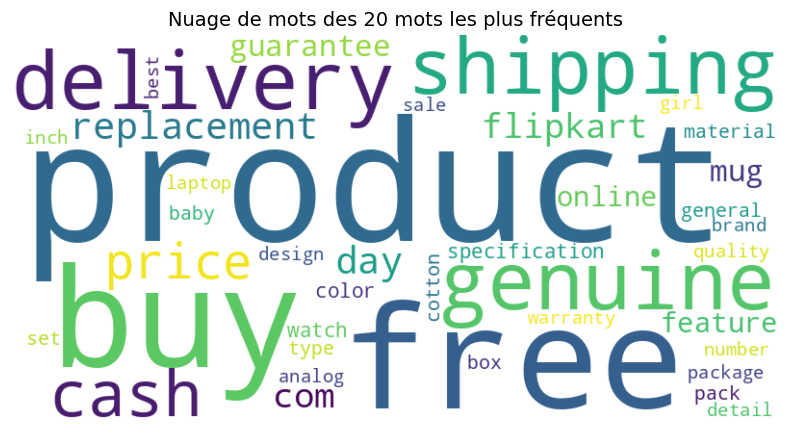

In [137]:
# Fusionner toutes les listes de tokens en une seule liste globale
all_words = [word for tokens in data["tokenized_description"] for word in tokens]

# Compter la fréquence des mots
word_counts = Counter(all_words)

# Sélectionner les 20 mots les plus fréquents
top_20_words = dict(word_counts.most_common(40))

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(top_20_words)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Cacher les axes
plt.title("Nuage de mots des 20 mots les plus fréquents", fontsize=14)
plt.show()


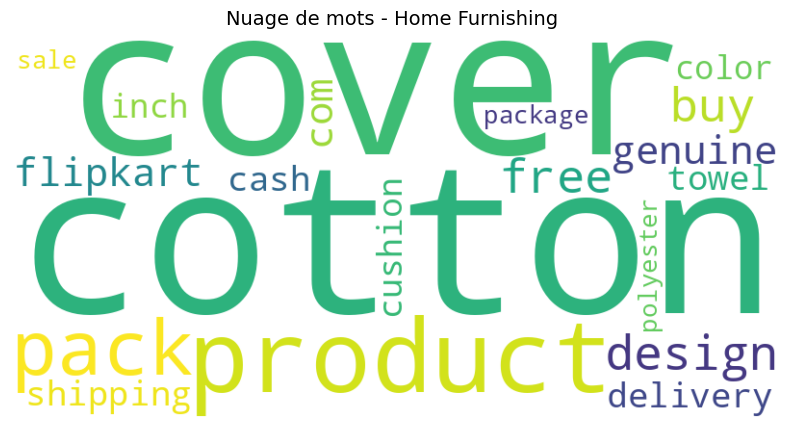

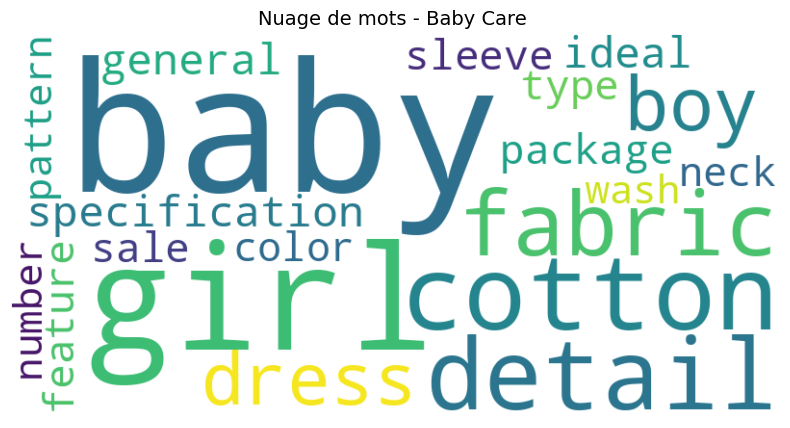

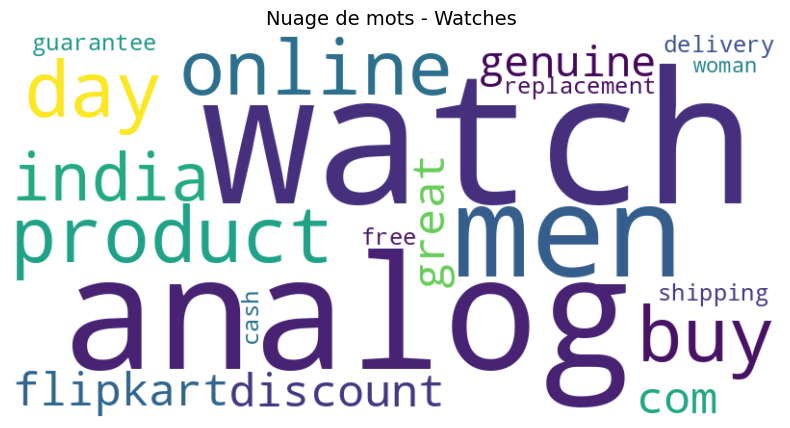

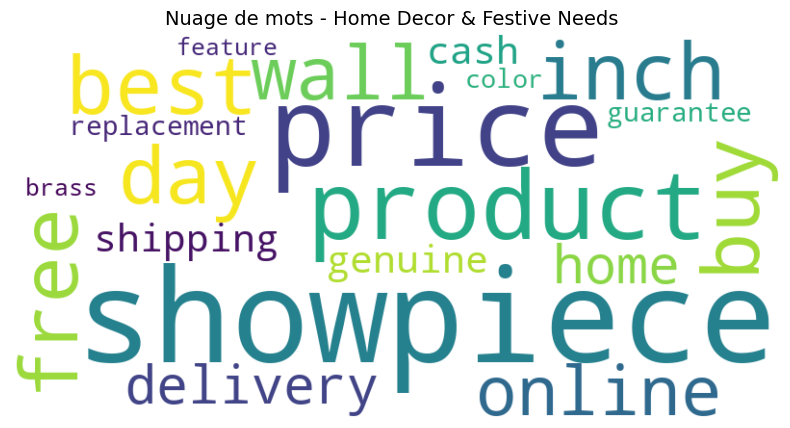

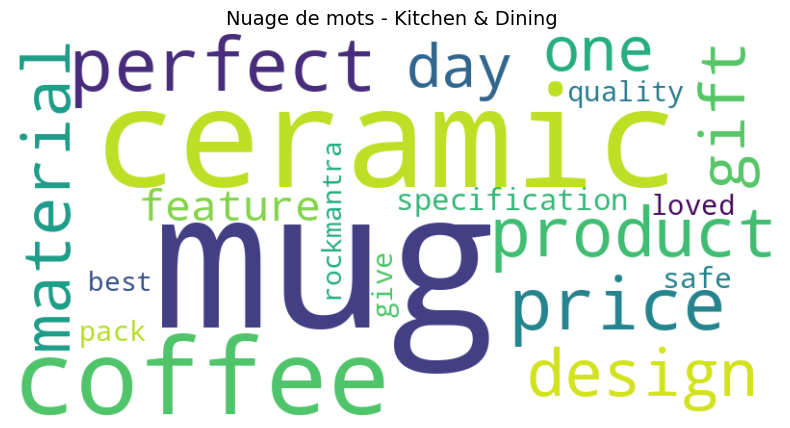

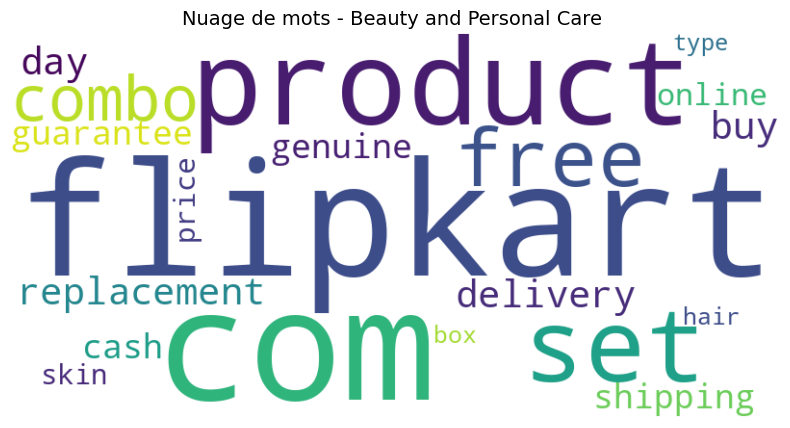

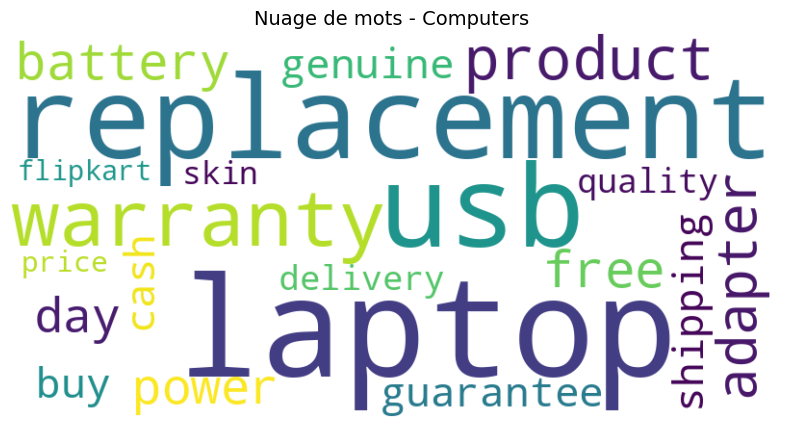

In [138]:
# Exécuter la fonction
generate_wordcloud_by_category(data)

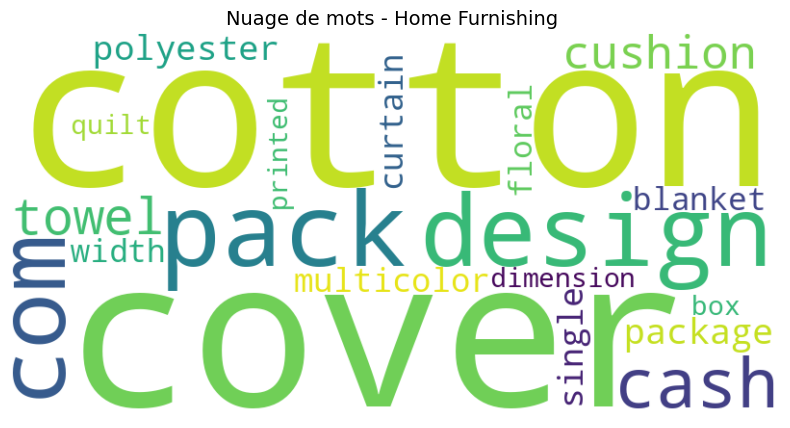

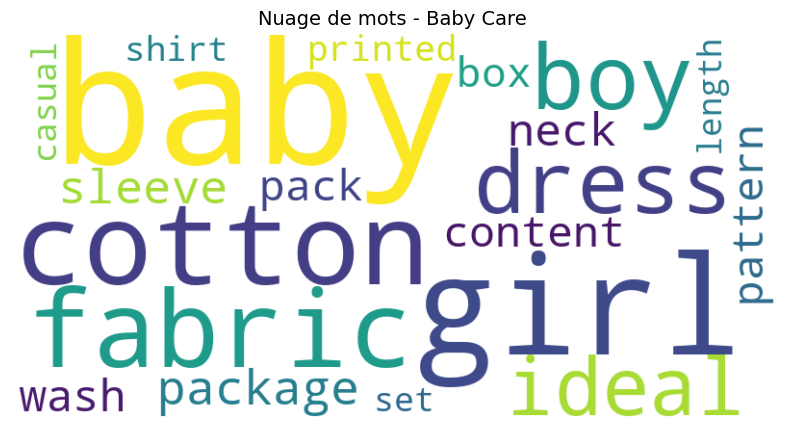

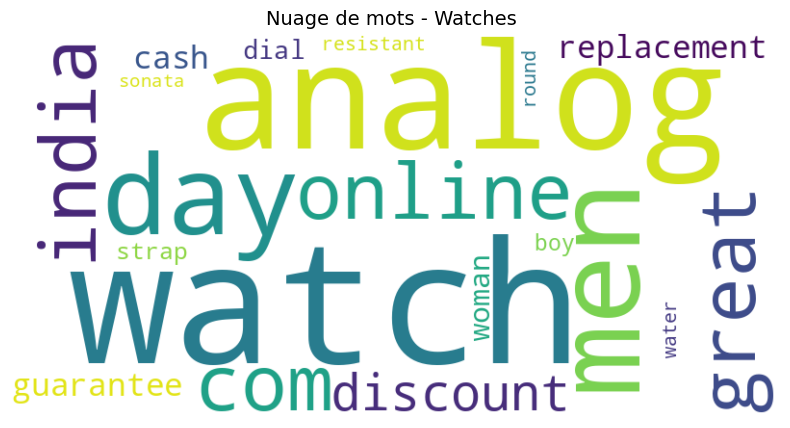

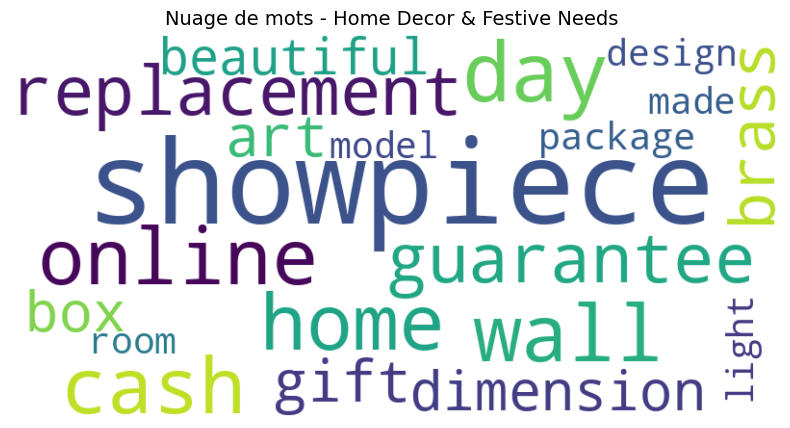

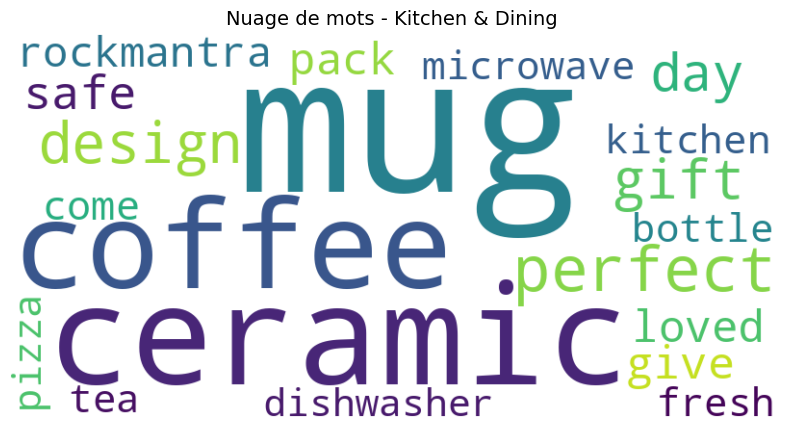

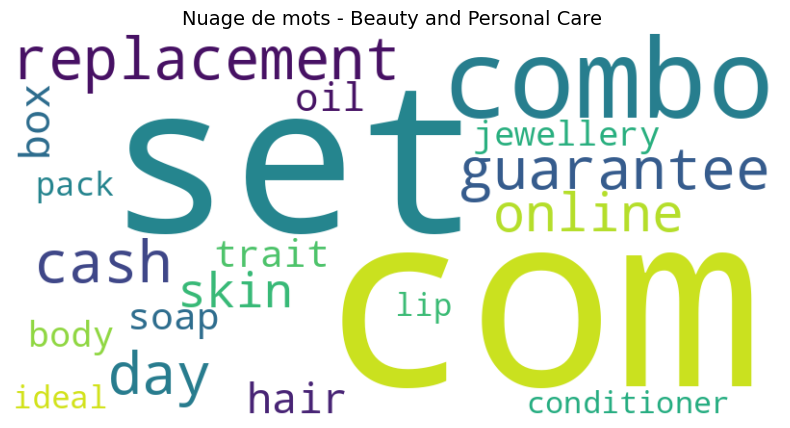

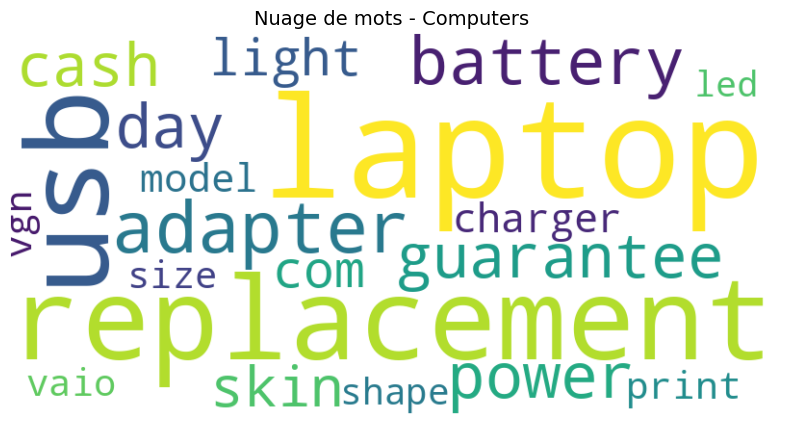

In [142]:
# Liste des mots non pertinents à exclure (mots trop génériques ou peu informatifs)
EXCLUDE_WORDS = {
    "product", "buy", "use", "price", "good", "best", "brand", "new", "one", "like", 
    "get", "free", "available", "sale", "offer", "flipkart", "delivery", "shipping", 
    "r", "key", "feature", "color", "type", "specification", "material", "general", 
    "number", "warranty", "detail", "quality", "inch", "genuine"
}


def generate_filtered_wordcloud_by_category(data, exclude_words=EXCLUDE_WORDS):
    """
    Génère un nuage de mots des 20 mots les plus fréquents pour chaque catégorie catA,
    en excluant les mots non pertinents.
    
    :param data: DataFrame contenant les colonnes 'catA' et 'tokenized_description'.
    :param exclude_words: Ensemble de mots à exclure du nuage de mots.
    """
    categories = data["catA"].unique()  # Liste des catégories uniques
    
    for category in categories:
        if pd.isnull(category):  # Ignorer les valeurs nulles
            continue
        
        # Filtrer les descriptions correspondant à cette catégorie
        category_data = data[data["catA"] == category]["tokenized_description"]

        # Fusionner toutes les listes de tokens en une seule liste de mots
        all_words = [word for tokens in category_data for word in tokens]

        # Filtrer les mots non pertinents
        filtered_words = [word for word in all_words if word not in exclude_words]

        if not filtered_words:  # Vérifier s'il y a des mots après filtrage
            print(f"Aucun mot pertinent trouvé pour la catégorie {category}")
            continue
        
        # Compter les occurrences des mots
        word_freq = Counter(filtered_words)

        # Sélectionner les 20 mots les plus fréquents
        most_common_words = dict(word_freq.most_common(20))

        # Générer le nuage de mots
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(most_common_words)

        # Afficher le nuage de mots
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")  # Masquer les axes
        plt.title(f"Nuage de mots - {category}", fontsize=14)
        plt.show()

# Exécuter la fonction avec le filtre actif
generate_filtered_wordcloud_by_category(data)

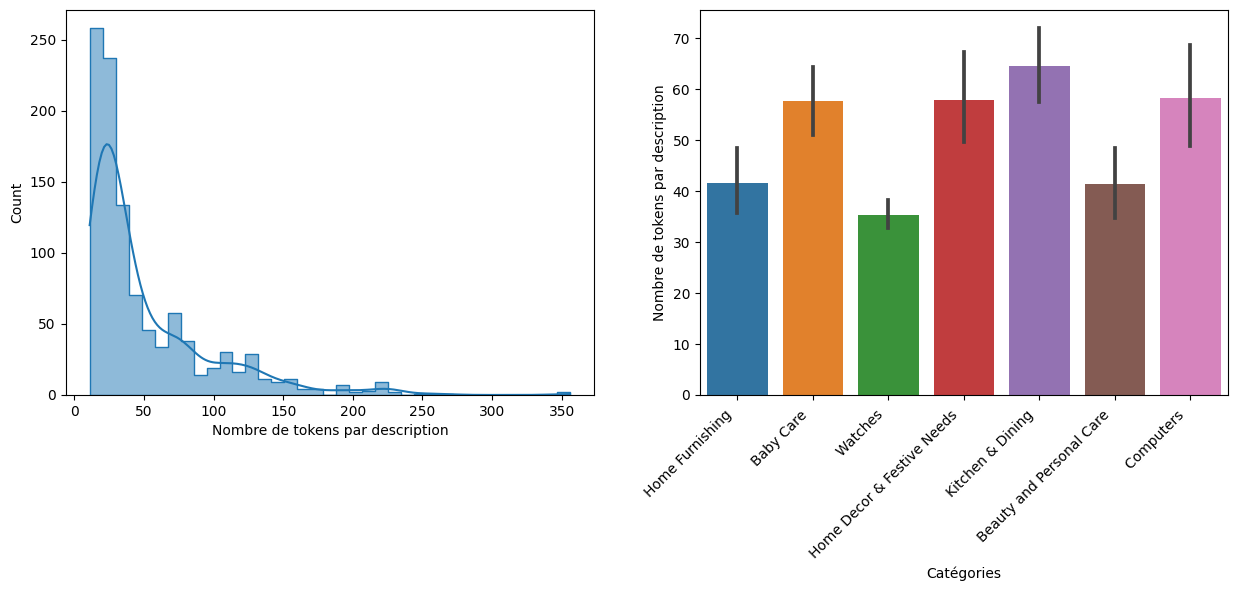

In [154]:
import seaborn as sns

# Définition de la figure
plt.figure(figsize=(15, 5))

# 📊 Histogramme du nombre de tokens par description
plt.subplot(121)
sns.histplot(x=data['tokenized_description'].str.len(), kde=True, element="step")
plt.xlabel("Nombre de tokens par description")

# 📊 Barplot du nombre de tokens par catégorie
plt.subplot(122)
len_categ_plot = sns.barplot(data=data, x=data['catA'], y=data['tokenized_description'].str.len())
plt.ylabel("Nombre de tokens par description")
plt.xlabel("Catégories")

# Rotation des étiquettes de l'axe X pour une meilleure lisibilité
len_categ_plot.set_xticklabels(
    len_categ_plot.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# Affichage des graphiques
plt.show()

In [207]:
data.to_csv("data_cleaned.csv", index= False)

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [208]:
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name               pid  \
0     Elegance Polyester Multicolor Abstract Eyelet ...  CRNEG7BKMFFYHQ8Z   
1                            Sathiyas Cotton Bath Towel  BTWEGFZHGBXPHZUH   
2                   Eurospa Cotton Terry Face Towel Set  BTWEG6SHXTDB2A2Y   
3     SANTOSH ROYAL FASHION Cotton Printed King size...  BDSEJT9UQWHDUBH4   
4     Jaipur Print Cotton Floral King sized Double B...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045     Oren Empower Extra Large Self Adhesive Sticker  STIE88ZGTX65GH4V   
1046             Wallmantra Large Vinyl Sticker Sticker  STIEC889ZD5GDCVQ   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...  STIE5UVGW2JWVWCT   
1048            Wallmantra Medium Vinyl Sticker Sticker  STIEC889ZGFD3RCE   
1049                       Uberlyfe Large Vinyl Sticker  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049        1190.0             595.0  f2f027ad6a6df617c9f125173da71e44.jpg   

      is_FK_Advantage_product  \
0                       False   
1                       False   
2                       False   
3                       False   
4                       False   
...                       ...   
1045                    False   
1046                    False   
1047                    False   
1048                    False   
1049                    False   

                                            description  ...  \
0     Key Features of Elegance Polyester Multicolor ...  ...   
1     Specifications of Sathiyas Cotton Bath Towel (...  ...   
2     Key Features of Eurospa Cotton Terry

In [166]:
import pandas as pd
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


# 📌 Télécharger les ressources nécessaires pour le NLP
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

# ✅ Définition des stopwords et du lemmatiseur
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    """
    Nettoie, tokenize et normalise le texte :
    - Suppression de la ponctuation et mise en minuscules
    - Tokenisation
    - Suppression des stopwords et des mots courts
    - Lemmatisation
    - Exclusion des mots non pertinents
    """
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # Suppression des caractères spéciaux et mise en minuscules
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())

    # Tokenisation
    tokenizer = RegexpTokenizer(r"\b\w+\b")
    tokens = tokenizer.tokenize(text)

    # Suppression des stopwords, mots courts et mots non pertinents
    filtered_tokens = [
        word for word in tokens 
        if word not in STOPWORDS and word not in EXCLUDE_WORDS and len(word) > 2
    ]

    # Lemmatisation
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # # Stemming
    # stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return " ".join(lemmatized_tokens)


# ✅ Application du prétraitement à la colonne "description"
data["cleaned_description"] = data["description"].apply(preprocess_text)

# 📌 Construction du Bag-of-Words (Comptage de mots)
vectorizer_bow = CountVectorizer(min_df=0.01, max_df=0.95)  # Seuils pour éviter mots rares/fréquents
bow_features = vectorizer_bow.fit_transform(data["cleaned_description"])

# 📌 Construction du TF-IDF (Pondération des mots)
vectorizer_tfidf = TfidfVectorizer(min_df=0.01, max_df=0.95)
tfidf_features = vectorizer_tfidf.fit_transform(data["cleaned_description"])

# ✅ Convertir les matrices en DataFrame pour affichage
df_bow = pd.DataFrame(bow_features.toarray(), columns=vectorizer_bow.get_feature_names_out())
df_tfidf = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

# 📌 Affichage des résultats
print("✅ Bag-of-Words (Aperçu) :")
print(df_bow.head())

print("\n✅ TF-IDF (Aperçu) :")
print(df_tfidf.head())

✅ Bag-of-Words (Aperçu) :
   abstract  accessory  actual  adapter  add  additional  adorable  \
0         4          0       0        0    0           0         0   
1         0          0       0        0    0           0         0   
2         0          0       0        0    0           0         0   
3         0          0       0        0    0           0         0   
4         0          0       0        0    0           0         0   

   affordable  age  also  ...  woman  wood  wooden  work  would  year  yellow  \
0           0    0     0  ...      0     0       0     0      0     0       0   
1           0    0     0  ...      1     0       0     0      0     0       2   
2           0    0     0  ...      1     0       0     0      0     1       0   
3           0    0     0  ...      0     0       0     0      0     0       0   
4           0    0     0  ...      0     0       0     0      0     0       0   

   yes  yet  youre  
0    0    0      0  
1    1    0      0  
2  

ARI : 0.0667
📉 Dimensions avant SVD : 458
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.1538


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


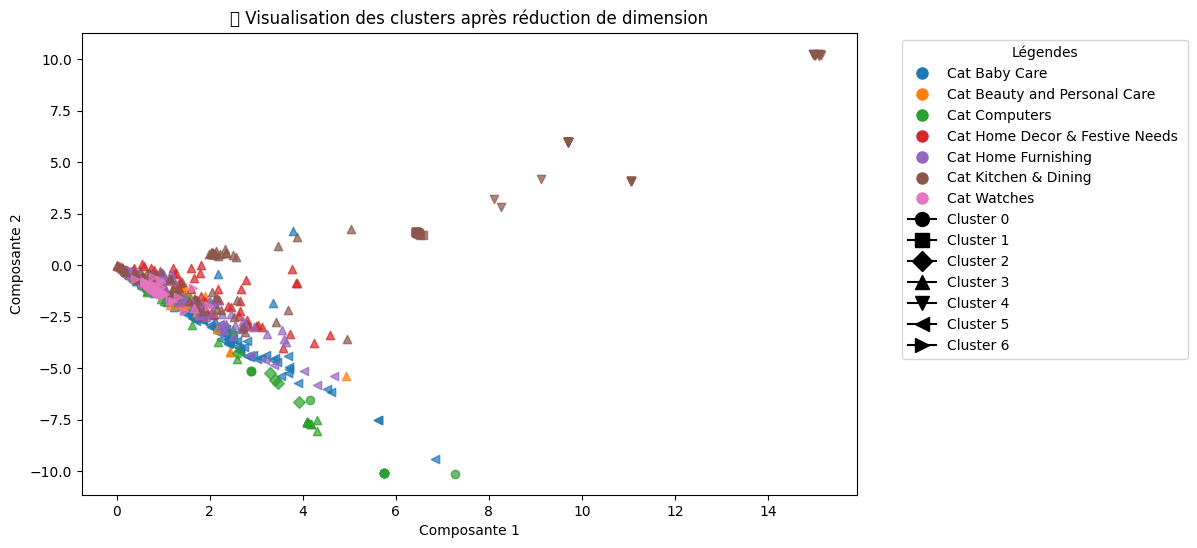

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.2829


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


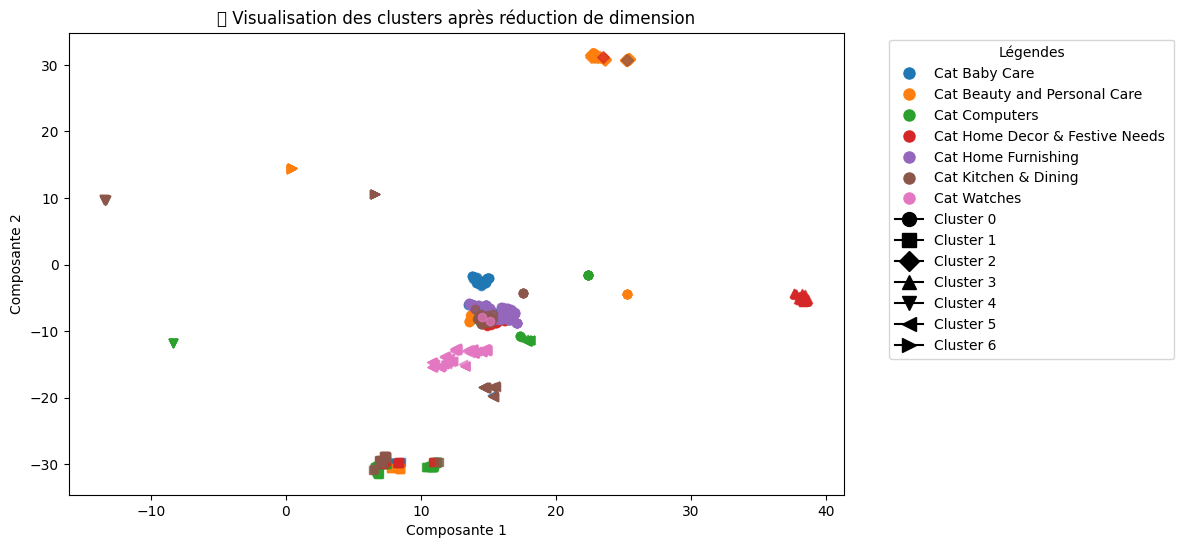

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.4660


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


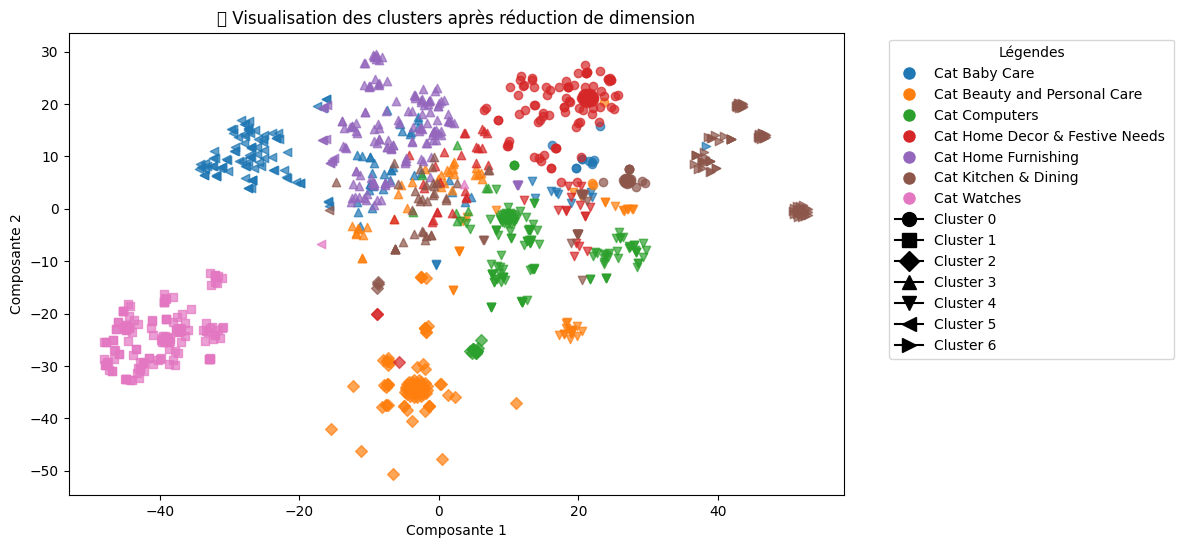


📊 Résultats ARI pour chaque méthode :
  Vectorizer Réduction                  ARI
0     TF-IDF      None  0.06671012311766952
1     TF-IDF       SVD  0.15377158797736956
2     TF-IDF      UMAP  0.28288040921031915
3     TF-IDF      TSNE  0.46598166321700546


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.lines as mlines


def kmeans_fct(features, true_labels, n_clusters):
    """
    Applique KMeans sur les données et calcule l'ARI (Adjusted Rand Index).
    
    :param features: Matrice de caractéristiques 
    :param true_labels: Labels réels des catégories
    :param n_clusters: Nombre de clusters pour KMeans
    :return: ARI, labels prédits
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pred_labels = kmeans.fit_predict(features)
    ari_score = adjusted_rand_score(true_labels, pred_labels)
    
    print(f"ARI : {ari_score:.4f}")
    return ari_score, pred_labels


def reduction_fct(features, method="SVD", n_components=100):
    """
    Réduit la dimensionnalité des données avec SVD, UMAP ou TSNE.
    
    :param features: Matrice de caractéristiques
    :param method: "SVD", "UMAP" ou "TSNE" pour choisir la réduction
    :param n_components: Nombre de dimensions après réduction
    :return: Matrice réduite
    """
    if method == "SVD":
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        features_reduced = svd.fit_transform(features)
        print(f"Dimensions avant SVD : {features.shape[1]}")
        print(f"Dimensions après SVD (99% var. explained): {n_components}")

    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
        features_reduced = reducer.fit_transform(features)
        print("Réduction de dimension avec UMAP")

    elif method == "TSNE":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
        features_reduced = reducer.fit_transform(features)
        print("Réduction de dimension avec TSNE")

    else:
        raise ValueError("Méthode non reconnue. Choisissez entre 'SVD', 'UMAP', ou 'TSNE'.")
    
    return features_reduced


def reduc_visu_fct(features, true_labels, pred_labels):
    """
    Visualise les résultats de réduction de dimension et de clustering avec :
    - Couleurs différentes pour les catégories réelles (catA)
    - Formes différentes pour chaque cluster prédit (KMeans)
    - Deux légendes distinctes : une pour la couleur et une pour la forme

    :param features: Matrice réduite (SVD, UMAP, TSNE)
    :param true_labels: Labels réels des catégories
    :param pred_labels: Labels prédits par KMeans
    """
    plt.figure(figsize=(10, 6))
    
    # Palette de couleurs pour les vraies catégories
    unique_true_labels = np.unique(true_labels)
    color_palette = sns.color_palette("tab10", len(unique_true_labels))
    
    # Liste de marqueurs pour les clusters prédits
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # 10 formes différentes

    # Tracer chaque point en fonction de sa vraie catégorie (couleur) et du cluster prédit (forme)
    for i, label in enumerate(unique_true_labels):
        for cluster in np.unique(pred_labels):
            mask = (true_labels == label) & (pred_labels == cluster)
            plt.scatter(
                features[mask, 0], features[mask, 1], 
                color=color_palette[i % len(color_palette)], 
                marker=markers[cluster % len(markers)], 
                alpha=0.7
            )

    # Ajouter une légende pour les couleurs (catégories réelles)
    category_legend = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[i], markersize=10, label=f"Cat {label}") 
                       for i, label in enumerate(unique_true_labels)]
    
    # Ajouter une légende pour les formes (clusters prédits)
    cluster_legend = [mlines.Line2D([0], [0], marker=markers[i % len(markers)], color='black', markersize=10, label=f"Cluster {i}") 
                      for i in np.unique(pred_labels)]

    # Affichage des légendes
    plt.legend(handles=category_legend + cluster_legend, title="Légendes", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.title("Visualisation des clusters après réduction de dimension")
    plt.show()


# 📌 Initialisation du tableau des résultats ARI
ARI_results = np.empty((0, 3), dtype=object)

# ✅ Étape 1 : Vectorisation avec comptage de mots
vectorizer_bow = CountVectorizer(min_df=0.01, max_df=0.95)  # Seuils pour éviter mots rares/fréquents
bow_features = vectorizer_bow.fit_transform(data["cleaned_description"])

# Nombre de clusters à utiliser
nb_clusters = len(data["catA"].unique())

# ✅ Étape 2 : KMeans sur les données vectorisées (Count)
ari, labels = kmeans_fct(bow_features, data["catA"], nb_clusters)
ARI_results = np.append(ARI_results, [["COunt", "None", ari]], axis=0)

# ✅ Étape 3 : Réduction SVD + KMeans
X_reduc_svd = reduction_fct(bow_features, method="SVD", n_components=100)
ari, labels = kmeans_fct(X_reduc_svd, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_svd, data["catA"], labels)
ARI_results = np.append(ARI_results, [["Count", "SVD", ari]], axis=0)

# ✅ Étape 4 : Réduction UMAP + KMeans
X_reduc_umap = reduction_fct(bow_features, method="UMAP")
ari, labels = kmeans_fct(X_reduc_umap, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_umap, data["catA"], labels)
ARI_results = np.append(ARI_results, [["count", "UMAP", ari]], axis=0)

# ✅ Étape 5 : Réduction TSNE + KMeans
X_reduc_tsne = reduction_fct(bow_features, method="TSNE")
ari, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)
ARI_results = np.append(ARI_results, [["count", "TSNE", ari]], axis=0)

# 📌 Affichage des résultats ARI finaux
print("\n📊 Résultats ARI pour chaque méthode :")
print(pd.DataFrame(ARI_results, columns=["Vectorizer", "Réduction", "ARI"]))


ARI : 0.2951
📉 Dimensions avant SVD : 428
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.2760


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


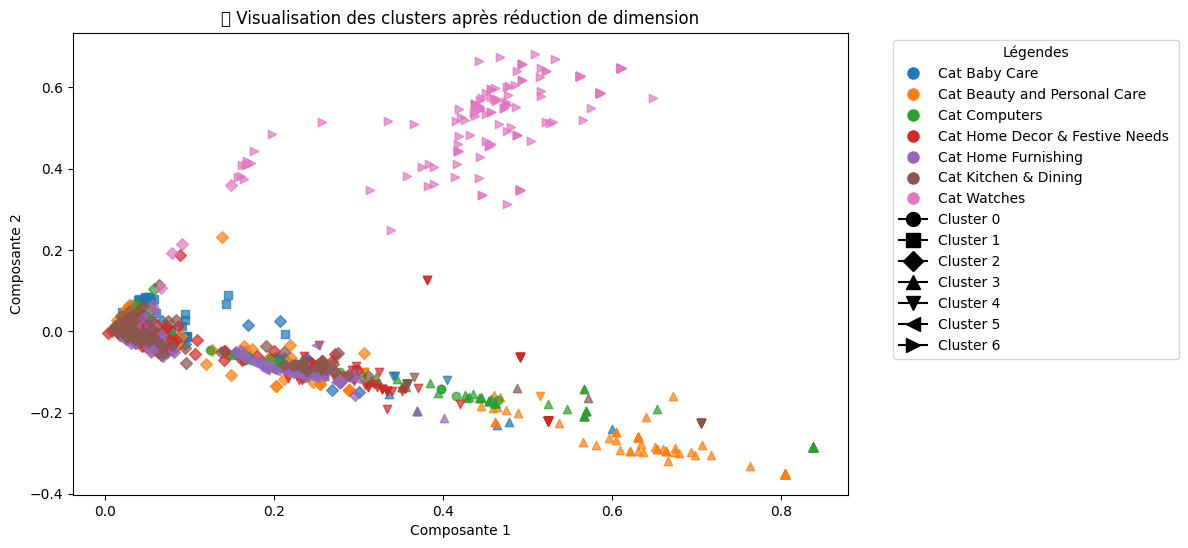

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.2111


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


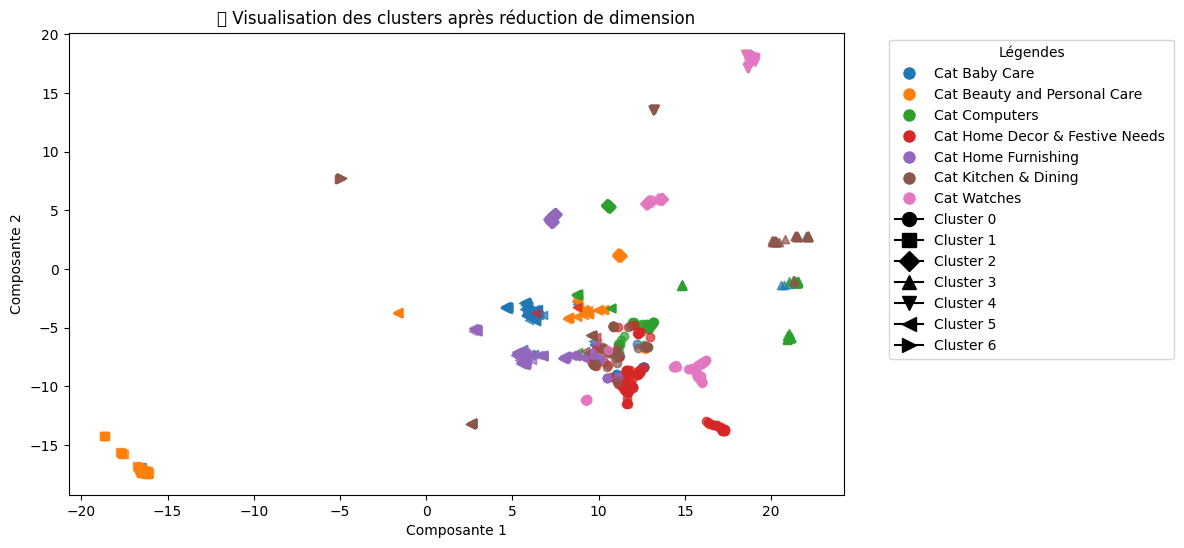

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.5561


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


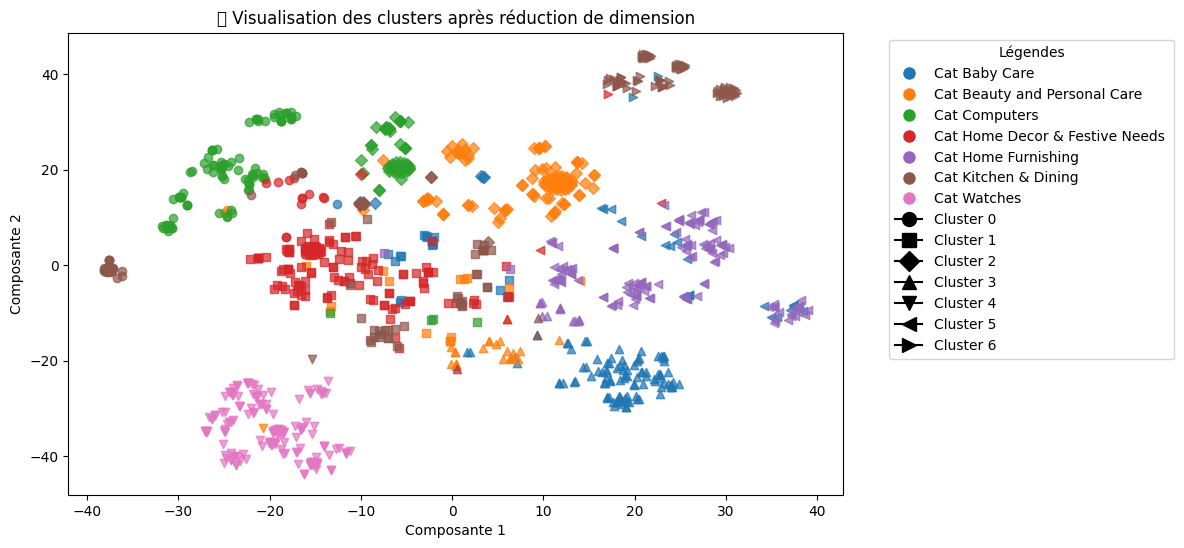


📊 Résultats ARI pour chaque méthode :
  Vectorizer Réduction                 ARI
0     TF-IDF      None   0.295070320517317
1     TF-IDF       SVD  0.2760353587695293
2     TF-IDF      UMAP  0.2111287451283393
3     TF-IDF      TSNE  0.5561036950210557


In [178]:
# 📌 Initialisation du tableau des résultats ARI
ARI_results = np.empty((0, 3), dtype=object)

# ✅ Étape 1 : Vectorisation avec TF-IDF
vectorizer_tfidf = TfidfVectorizer(stop_words="english", min_df=0.01, max_df=0.95)
tfidf_transform = vectorizer_tfidf.fit_transform(data["cleaned_description"])

# Nombre de clusters à utiliser
nb_clusters = len(data["catA"].unique())

# ✅ Étape 2 : KMeans sur les données vectorisées (TF-IDF brut)
ari, labels = kmeans_fct(tfidf_transform, data["catA"], nb_clusters)
ARI_results = np.append(ARI_results, [["TF-IDF", "None", ari]], axis=0)

# ✅ Étape 3 : Réduction SVD + KMeans
X_reduc_svd = reduction_fct(tfidf_transform, method="SVD", n_components=100)
ari, labels = kmeans_fct(X_reduc_svd, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_svd, data["catA"], labels)
ARI_results = np.append(ARI_results, [["TF-IDF", "SVD", ari]], axis=0)

# ✅ Étape 4 : Réduction UMAP + KMeans
X_reduc_umap = reduction_fct(tfidf_transform, method="UMAP")
ari, labels = kmeans_fct(X_reduc_umap, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_umap, data["catA"], labels)
ARI_results = np.append(ARI_results, [["TF-IDF", "UMAP", ari]], axis=0)

# ✅ Étape 5 : Réduction TSNE + KMeans
X_reduc_tsne = reduction_fct(tfidf_transform, method="TSNE")
ari, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)
ARI_results = np.append(ARI_results, [["TF-IDF", "TSNE", ari]], axis=0)

# 📌 Affichage des résultats ARI finaux
print("\n📊 Résultats ARI pour chaque méthode :")
print(pd.DataFrame(ARI_results, columns=["Vectorizer", "Réduction", "ARI"]))


In [181]:
from gensim.models import Word2Vec

def train_word2vec(texts, vector_size=100, min_count=1, workers=4, sg=1):
    """
    Entraîne un modèle Word2Vec sur les descriptions en mode CBOW ou Skip-Gram.
    
    :param texts: Liste de listes de mots tokenisés
    :param vector_size: Taille des vecteurs Word2Vec
    :param min_count: Fréquence minimale d'apparition d'un mot
    :param workers: Nombre de threads pour le calcul
    :param sg: 0 = CBOW, 1 = Skip-Gram
    :return: Modèle Word2Vec entraîné
    """
    model = Word2Vec(sentences=texts, vector_size=vector_size, min_count=min_count, workers=workers, sg=sg)
    return model


def get_sentence_vectors(model, texts):
    """
    Convertit une liste de descriptions tokenisées en vecteurs de phrases 
    en moyennant les vecteurs Word2Vec des mots.
    
    :param model: Modèle Word2Vec entraîné
    :param texts: Liste de listes de mots tokenisés
    :return: Matrice (nb_descriptions, vector_size)
    """
    vector_size = model.vector_size
    sentence_vectors = []

    for words in texts:
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            sentence_vector = np.mean(word_vectors, axis=0)  # Moyenne des vecteurs des mots
        else:
            sentence_vector = np.zeros(vector_size)  # Si aucun mot connu, vecteur nul
        sentence_vectors.append(sentence_vector)

    return np.array(sentence_vectors)


# 📌 Préparation des données pour Word2Vec
tokenized_texts = data["cleaned_description"].apply(lambda x: x.split()).tolist()

# ✅ Entraînement du modèle Word2Vec en mode CBOW (sg=0)
print("🔵 Entraînement Word2Vec - CBOW")
word2vec_model_cbow = train_word2vec(tokenized_texts, sg=0)
word2vec_features_cbow = get_sentence_vectors(word2vec_model_cbow, tokenized_texts)

# ✅ Entraînement du modèle Word2Vec en mode Skip-Gram (sg=1)
print("🟠 Entraînement Word2Vec - Skip-Gram")
word2vec_model_sg = train_word2vec(tokenized_texts, sg=1)
word2vec_features_sg = get_sentence_vectors(word2vec_model_sg, tokenized_texts)



🔵 Entraînement Word2Vec - CBOW
🟠 Entraînement Word2Vec - Skip-Gram


ARI : 0.1343
📉 Dimensions avant SVD : 100
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.1343


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


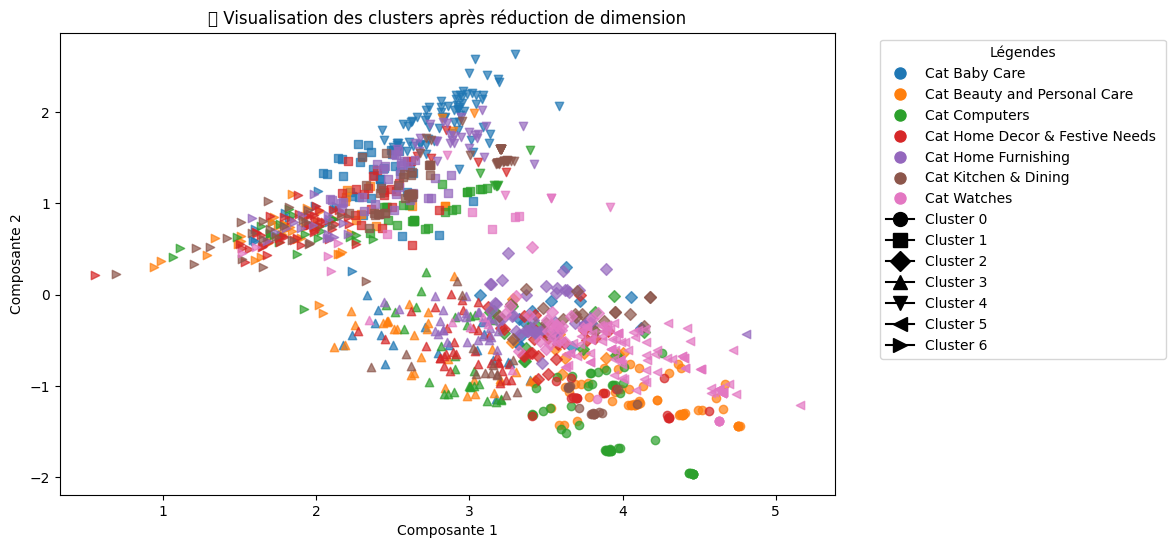

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.1771


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


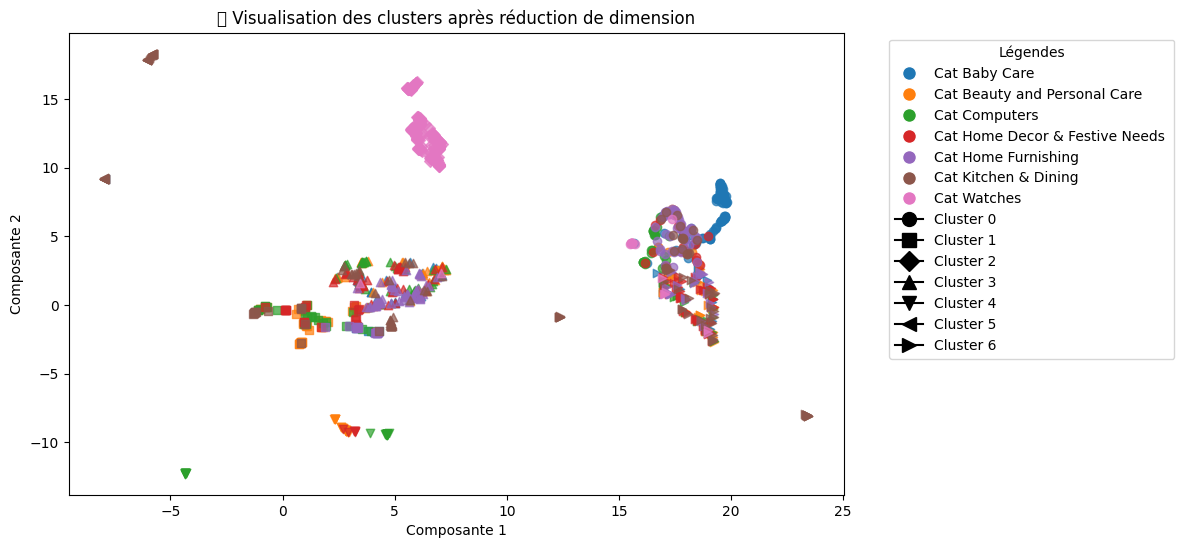

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.1967


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


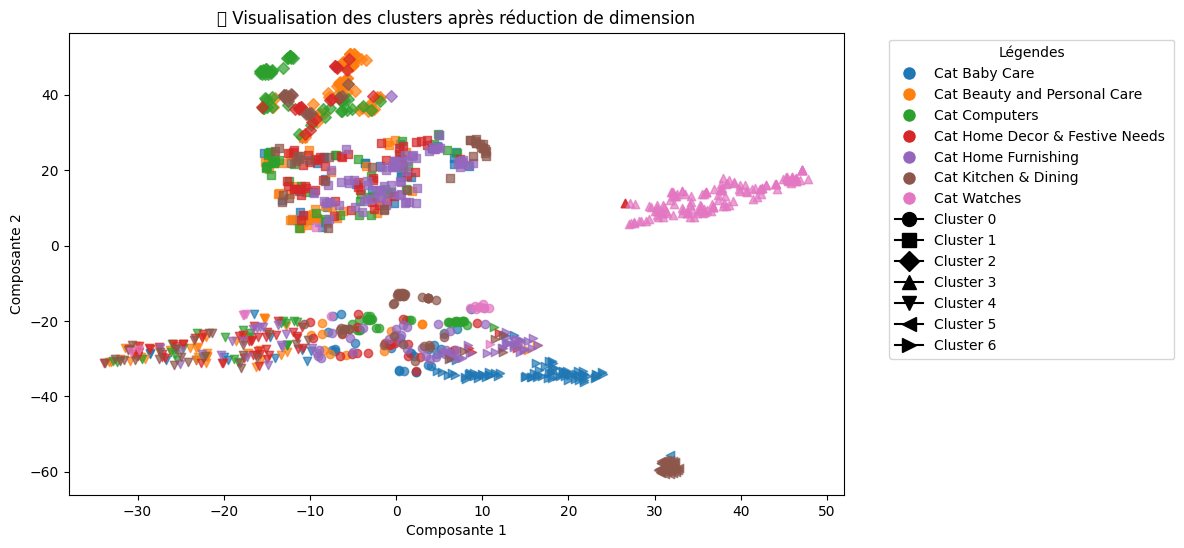

In [182]:
# 📌 Détermination du nombre de clusters
nb_clusters = len(data["catA"].unique())

# ✅ Clustering avec KMeans sur Word2Vec brut
ari, labels = kmeans_fct(word2vec_features_cbow, data["catA"], nb_clusters)

# ✅ Réduction SVD + KMeans
X_reduc_svd = reduction_fct(word2vec_features_cbow, method="SVD", n_components=100)
ari, labels = kmeans_fct(X_reduc_svd, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_svd, data["catA"], labels)

# ✅ Réduction UMAP + KMeans
X_reduc_umap = reduction_fct(word2vec_features_cbow, method="UMAP")
ari, labels = kmeans_fct(X_reduc_umap, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_umap, data["catA"], labels)

# ✅ Réduction TSNE + KMeans
X_reduc_tsne = reduction_fct(word2vec_features_cbow, method="TSNE")
ari, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)

ARI : 0.2570
📉 Dimensions avant SVD : 100
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.2570


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


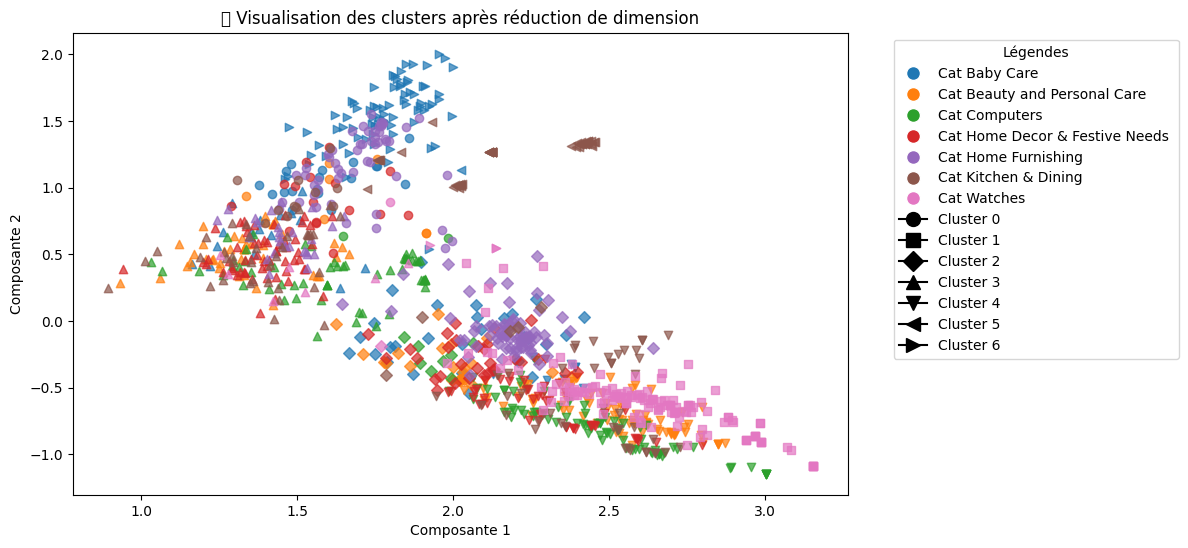

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.2508


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


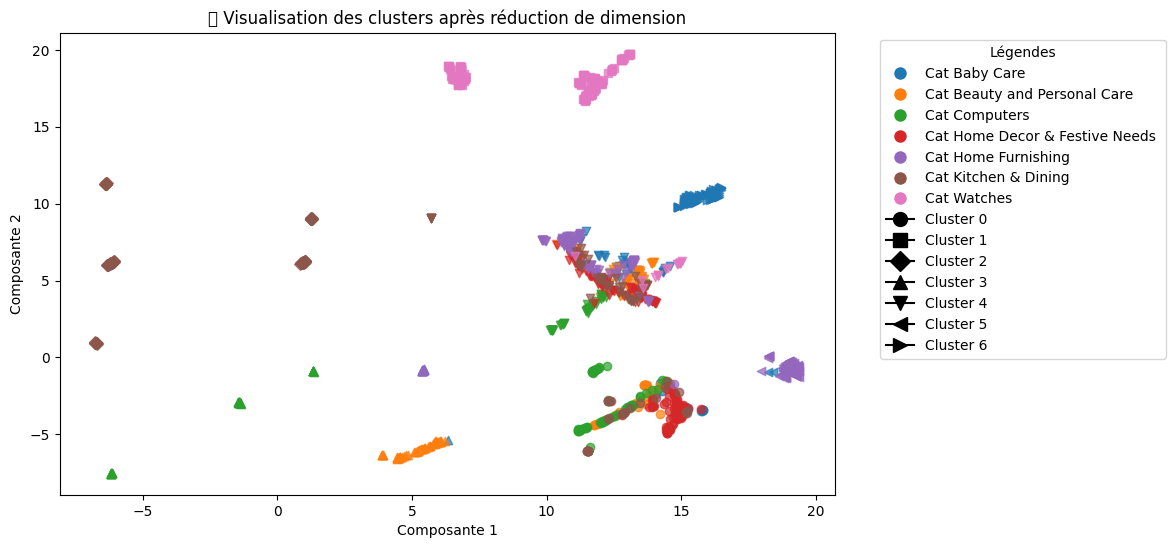

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.2884


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


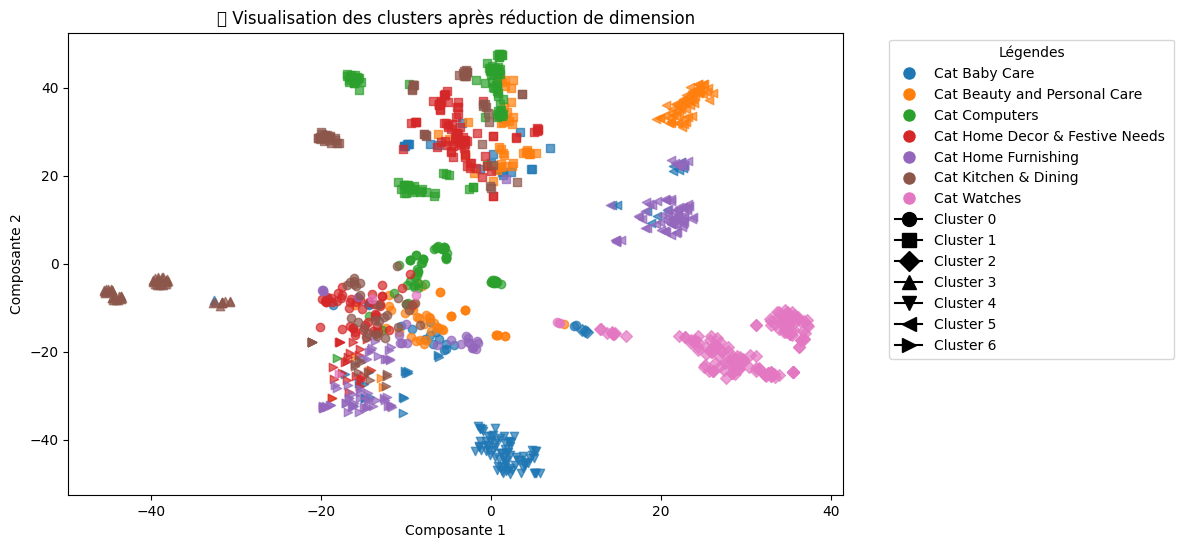

In [183]:
# 📌 Détermination du nombre de clusters
nb_clusters = len(data["catA"].unique())

# ✅ Clustering avec KMeans sur Word2Vec brut
ari, labels = kmeans_fct(word2vec_features_sg, data["catA"], nb_clusters)

# ✅ Réduction SVD + KMeans
X_reduc_svd = reduction_fct(word2vec_features_sg, method="SVD", n_components=100)
ari, labels = kmeans_fct(X_reduc_svd, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_svd, data["catA"], labels)

# ✅ Réduction UMAP + KMeans
X_reduc_umap = reduction_fct(word2vec_features_sg, method="UMAP")
ari, labels = kmeans_fct(X_reduc_umap, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_umap, data["catA"], labels)

# ✅ Réduction TSNE + KMeans
X_reduc_tsne = reduction_fct(word2vec_features_sg, method="TSNE")
ari, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)

In [185]:
import tensorflow as tf
import tensorflow_hub as hub

def load_bert_encoder():
    """
    Charge l'encodeur BERT depuis TensorFlow Hub.
    
    :return: Modèle BERT pour l'encodage des phrases.
    """
    print("🔵 Chargement de l'encodeur BERT...")
    encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    return encoder


def get_bert_embeddings(encoder, texts):
    """
    Convertit une liste de phrases en embeddings BERT.
    
    :param encoder: Modèle BERT chargé via TensorFlow Hub.
    :param texts: Liste de phrases (descriptions).
    :return: Matrice d'embeddings (nb_descriptions, 512).
    """
    print("🟠 Encodage des descriptions avec BERT...")
    embeddings = encoder(texts)
    return np.array(embeddings)


🔵 Chargement de l'encodeur BERT...
🟠 Encodage des descriptions avec BERT...
ARI : 0.3462
📉 Dimensions avant SVD : 512
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.3561


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


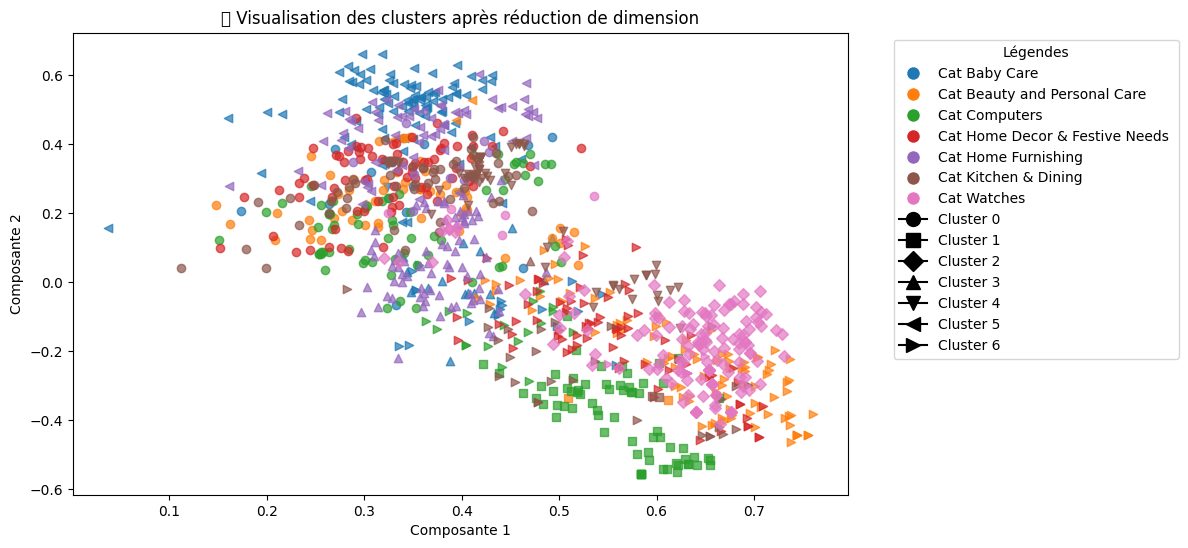

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.3455


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


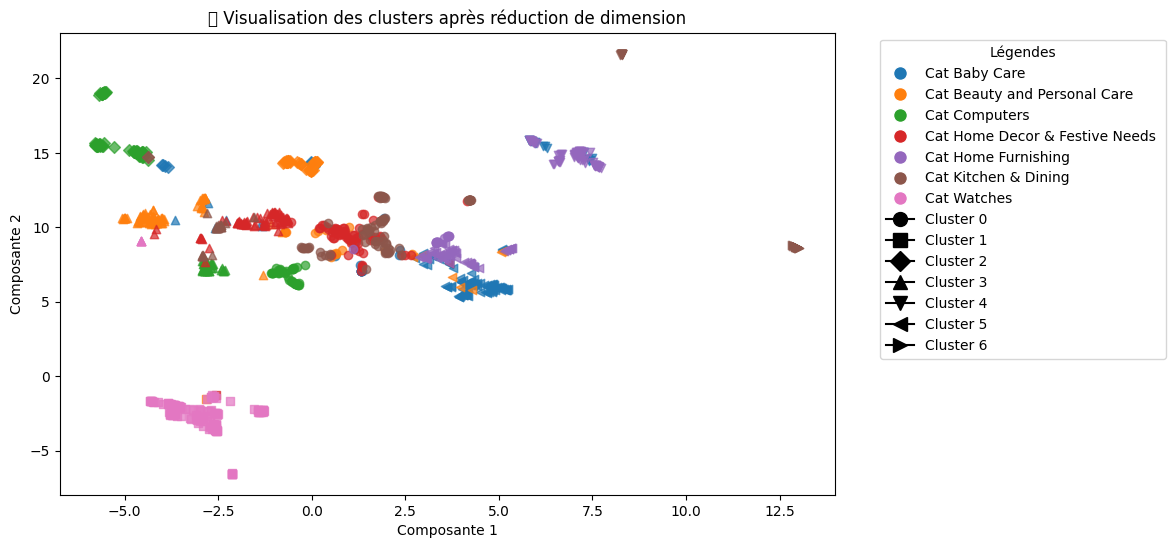

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.4494


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


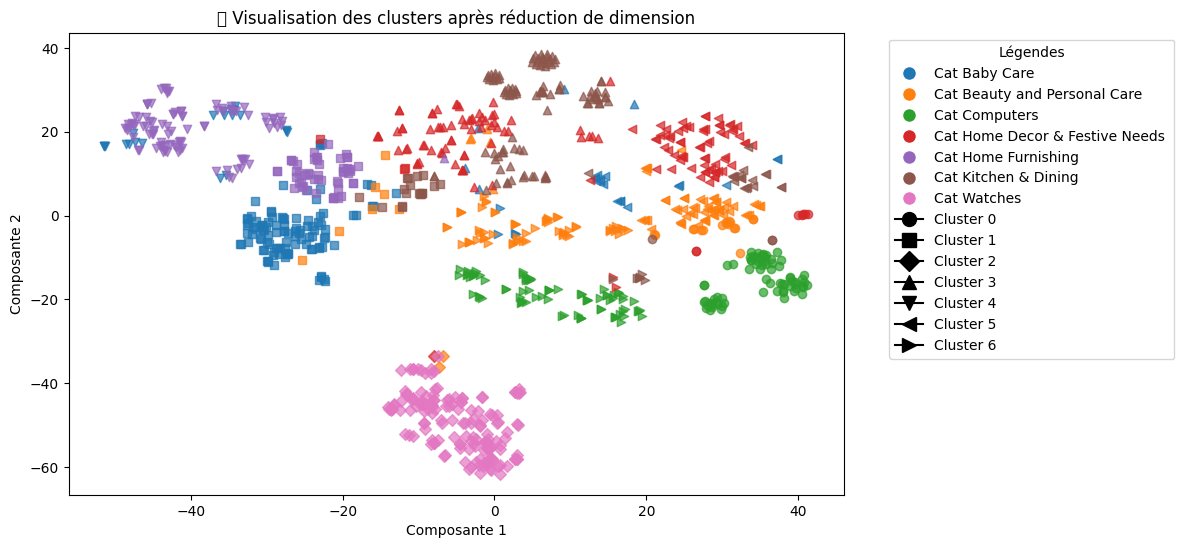

In [186]:
# 📌 Chargement de BERT
bert_encoder = load_bert_encoder()

# ✅ Encodage des descriptions avec BERT
bert_features = get_bert_embeddings(bert_encoder, data["cleaned_description"].tolist())

# 📌 Détermination du nombre de clusters
nb_clusters = len(data["catA"].unique())

# ✅ Clustering avec KMeans sur BERT brut
ari, labels = kmeans_fct(bert_features, data["catA"], nb_clusters)

# ✅ Réduction SVD + KMeans
X_reduc_svd = reduction_fct(bert_features, method="SVD", n_components=100)
ari, labels = kmeans_fct(X_reduc_svd, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_svd, data["catA"], labels)

# ✅ Réduction UMAP + KMeans
X_reduc_umap = reduction_fct(bert_features, method="UMAP")
ari, labels = kmeans_fct(X_reduc_umap, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_umap, data["catA"], labels)

# ✅ Réduction TSNE + KMeans
X_reduc_tsne = reduction_fct(bert_features, method="TSNE")
ari, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)

In [187]:
import torch
from sentence_transformers import SentenceTransformer

def load_sbert_encoder():
    """
    Charge le modèle Sentence-BERT depuis `sentence-transformers`.
    
    :return: Modèle SBERT pour l'encodage des phrases.
    """
    print("🔵 Chargement du modèle Sentence-BERT...")
    model = SentenceTransformer("all-MiniLM-L6-v2")  # Modèle léger et rapide
    return model


def get_sbert_embeddings(model, texts):
    """
    Convertit une liste de descriptions en embeddings SBERT.
    
    :param model: Modèle SBERT chargé.
    :param texts: Liste de descriptions.
    :return: Matrice d'embeddings (nb_descriptions, 384).
    """
    print("🟠 Encodage des descriptions avec SBERT...")
    embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)
    return embeddings

🔵 Chargement du modèle Sentence-BERT...
🟠 Encodage des descriptions avec SBERT...


Batches: 100%|██████████| 33/33 [00:20<00:00,  1.60it/s]


ARI : 0.3851
📉 Dimensions avant SVD : 384
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.3671


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


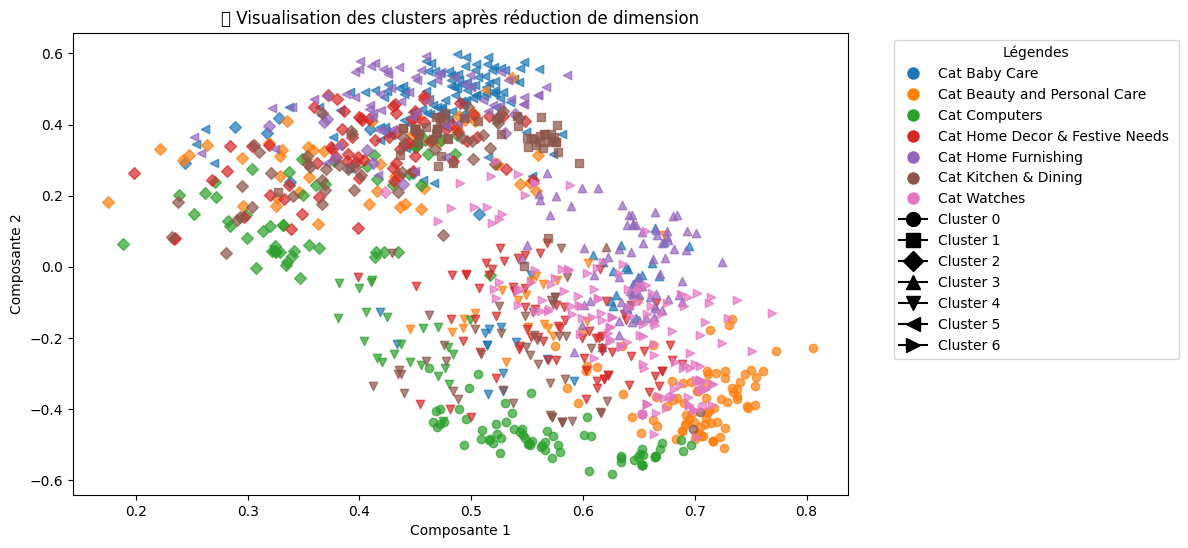

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.4523


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


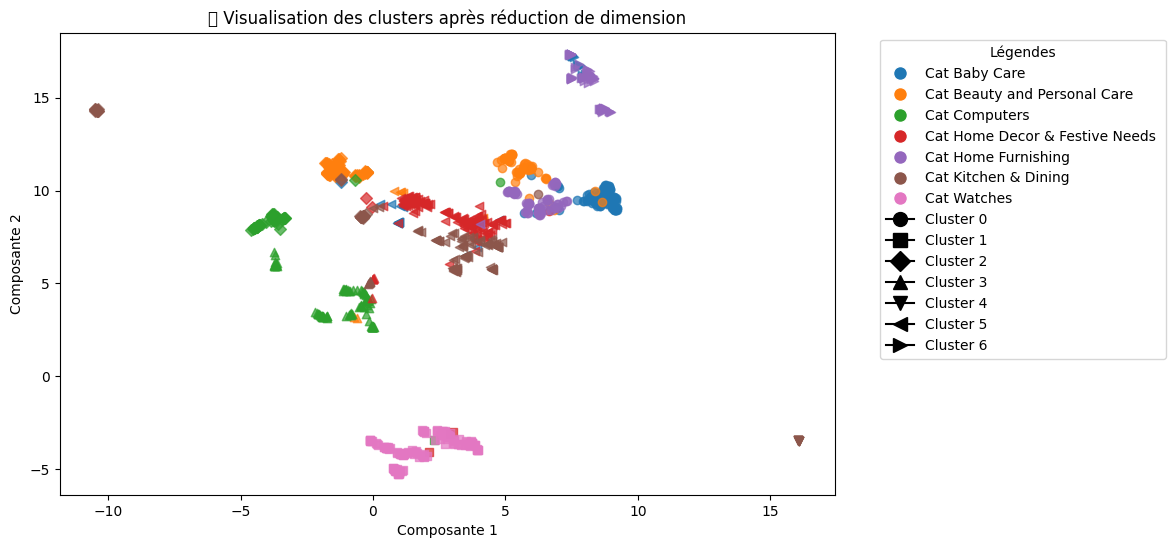

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.4455


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


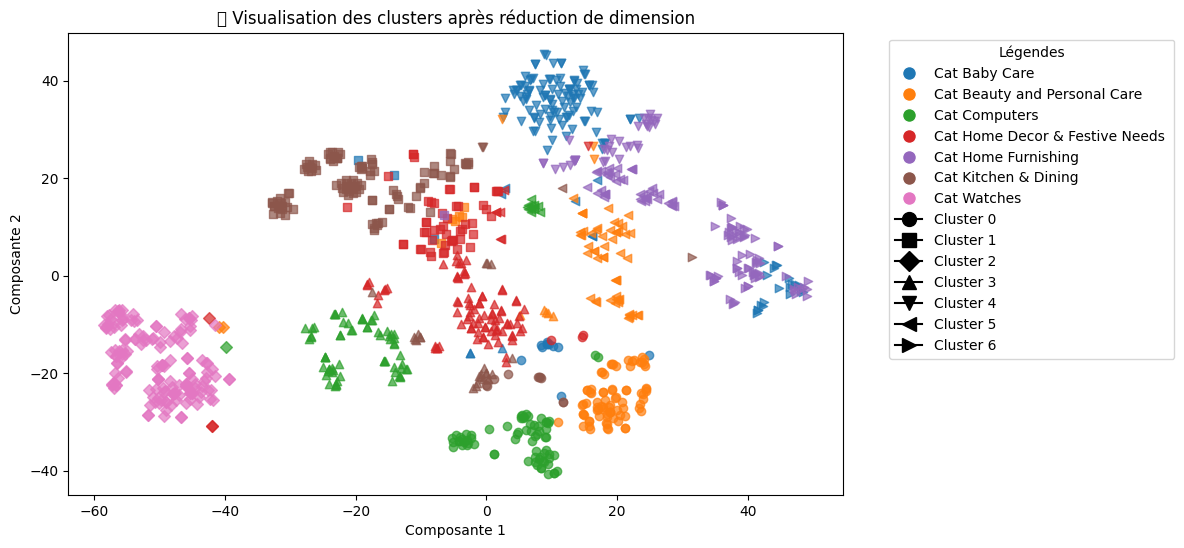

In [188]:
# 📌 Chargement de SBERT
sbert_model = load_sbert_encoder()

# ✅ Encodage des descriptions avec SBERT
sbert_features = get_sbert_embeddings(sbert_model, data["cleaned_description"].tolist())

# 📌 Détermination du nombre de clusters
nb_clusters = len(data["catA"].unique())

# ✅ Clustering avec KMeans sur SBERT brut
ari, labels = kmeans_fct(sbert_features, data["catA"], nb_clusters)

# ✅ Réduction SVD + KMeans
X_reduc_svd = reduction_fct(sbert_features, method="SVD", n_components=100)
ari, labels = kmeans_fct(X_reduc_svd, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_svd, data["catA"], labels)

# ✅ Réduction UMAP + KMeans
X_reduc_umap = reduction_fct(sbert_features, method="UMAP")
ari, labels = kmeans_fct(X_reduc_umap, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_umap, data["catA"], labels)

# ✅ Réduction TSNE + KMeans
X_reduc_tsne = reduction_fct(sbert_features, method="TSNE")
ari, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)

In [190]:
def load_use_encoder():
    """
    Charge Universal Sentence Encoder depuis TensorFlow Hub.
    
    :return: Modèle USE pour l'encodage des phrases.
    """
    print("🔵 Chargement du modèle Universal Sentence Encoder...")
    encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    return encoder


def get_use_embeddings(encoder, texts):
    """
    Convertit une liste de descriptions en embeddings USE.
    
    :param encoder: Modèle USE chargé via TensorFlow Hub.
    :param texts: Liste de descriptions.
    :return: Matrice d'embeddings (nb_descriptions, 512).
    """
    print("🟠 Encodage des descriptions avec USE...")
    embeddings = encoder(texts)
    return np.array(embeddings)

🔵 Chargement du modèle Universal Sentence Encoder...
🟠 Encodage des descriptions avec USE...
ARI : 0.3462
📉 Dimensions avant SVD : 512
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.3561


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


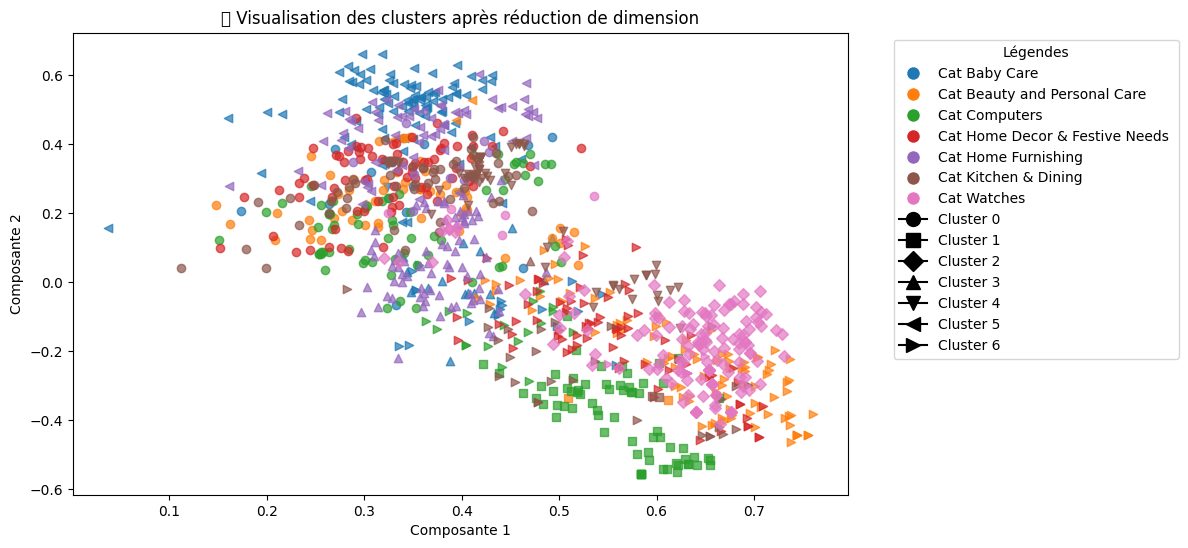

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.3455


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


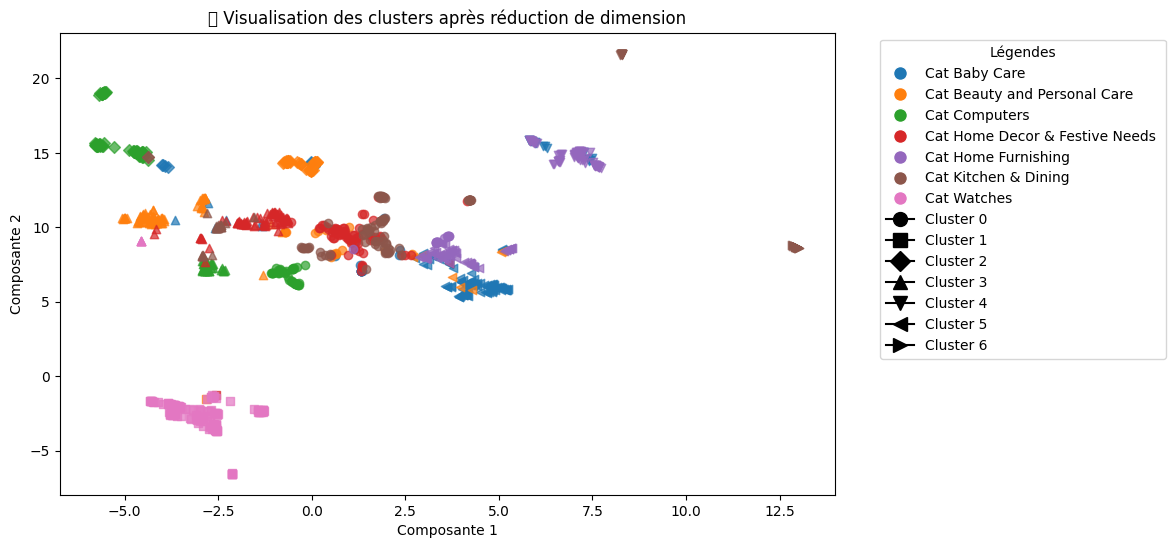

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.4494


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


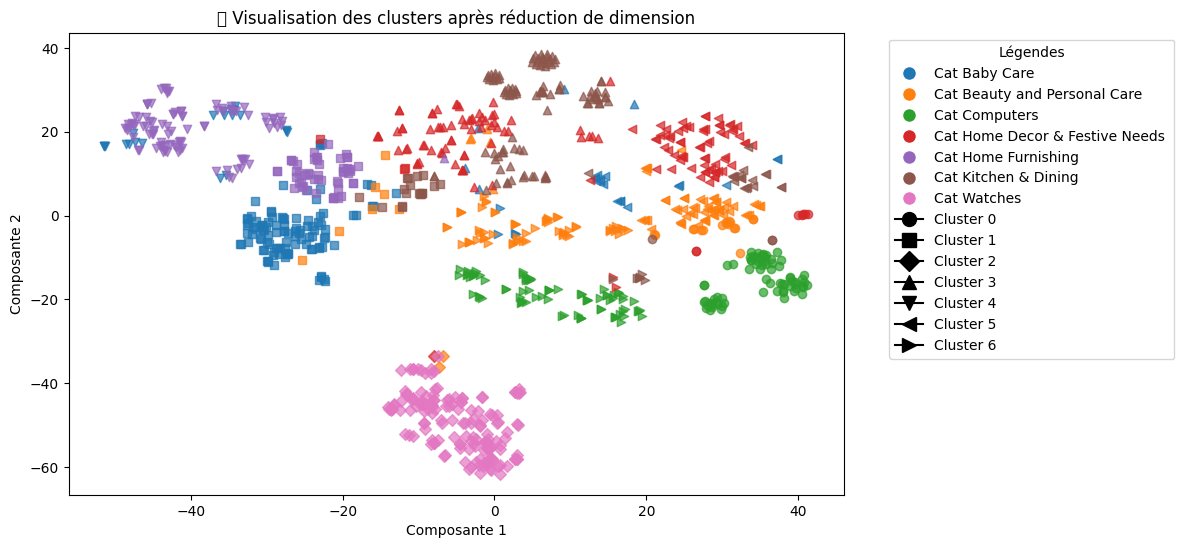

In [191]:
# 📌 Chargement du modèle Universal Sentence Encoder
use_encoder = load_use_encoder()

# ✅ Encodage des descriptions avec USE
use_features = get_use_embeddings(use_encoder, data["cleaned_description"].tolist())

# 📌 Détermination du nombre de clusters
nb_clusters = len(data["catA"].unique())

# ✅ Clustering avec KMeans sur USE brut
ari, labels = kmeans_fct(use_features, data["catA"], nb_clusters)

# ✅ Réduction SVD + KMeans
X_reduc_svd = reduction_fct(use_features, method="SVD", n_components=100)
ari, labels = kmeans_fct(X_reduc_svd, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_svd, data["catA"], labels)

# ✅ Réduction UMAP + KMeans
X_reduc_umap = reduction_fct(use_features, method="UMAP")
ari, labels = kmeans_fct(X_reduc_umap, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_umap, data["catA"], labels)

# ✅ Réduction TSNE + KMeans
X_reduc_tsne = reduction_fct(use_features, method="TSNE")
ari, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)

In [196]:
# 📌 Détermination du nombre de clusters
nb_clusters = len(data["catA"].unique())

# 📌 Initialisation des résultats ARI
ari_results = []

### **✅ 1. Count Vectorizer (Bag-of-Words)**
vectorizer_count = CountVectorizer(stop_words="english", min_df=0.01, max_df=0.95)
count_features = vectorizer_count.fit_transform(data["cleaned_description"])
for method in ["SVD", "UMAP", "TSNE"]:
    reduced_count = reduction_fct(count_features.toarray(), method=method)
    ari = kmeans_fct(reduced_count, data["catA"], nb_clusters)
    ari_results.append(["CountVectorizer", method, ari])

### **✅ 2. TF-IDF**
vectorizer_tfidf = TfidfVectorizer(stop_words="english", min_df=0.01, max_df=0.95)
tfidf_features = vectorizer_tfidf.fit_transform(data["cleaned_description"])
for method in ["SVD", "UMAP", "TSNE"]:
    reduced_tfidf = reduction_fct(tfidf_features.toarray(), method=method)
    ari = kmeans_fct(reduced_tfidf, data["catA"], nb_clusters)
    ari_results.append(["TF-IDF", method, ari])

### **✅ 3. Word2Vec (CBOW)**
tokenized_texts = data["cleaned_description"].apply(lambda x: x.split()).tolist()
word2vec_cbow = Word2Vec(sentences=tokenized_texts, vector_size=100, min_count=1, workers=4, sg=0)
word2vec_features_cbow = np.array([
    np.mean([word2vec_cbow.wv[word] for word in words if word in word2vec_cbow.wv] or [np.zeros(100)], axis=0)
    for words in tokenized_texts
])
for method in ["SVD", "UMAP", "TSNE"]:
    reduced_w2v_cbow = reduction_fct(word2vec_features_cbow, method=method)
    ari = kmeans_fct(reduced_w2v_cbow, data["catA"], nb_clusters)
    ari_results.append(["Word2Vec-CBOW", method, ari])

### **✅ 4. Word2Vec (Skip-Gram)**
word2vec_sg = Word2Vec(sentences=tokenized_texts, vector_size=100, min_count=1, workers=4, sg=1)
word2vec_features_sg = np.array([
    np.mean([word2vec_sg.wv[word] for word in words if word in word2vec_sg.wv] or [np.zeros(100)], axis=0)
    for words in tokenized_texts
])
for method in ["SVD", "UMAP", "TSNE"]:
    reduced_w2v_sg = reduction_fct(word2vec_features_sg, method=method)
    ari = kmeans_fct(reduced_w2v_sg, data["catA"], nb_clusters)
    ari_results.append(["Word2Vec-SkipGram", method, ari])

### **✅ 5. SBERT**
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
sbert_features = sbert_model.encode(data["cleaned_description"].tolist(), convert_to_numpy=True, show_progress_bar=True)
for method in ["SVD", "UMAP", "TSNE"]:
    reduced_sbert = reduction_fct(sbert_features, method=method)
    ari = kmeans_fct(reduced_sbert, data["catA"], nb_clusters)
    ari_results.append(["SBERT", method, ari])

### **✅ 6. USE**
use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
use_features = np.array(use_encoder(data["cleaned_description"].tolist()))
for method in ["SVD", "UMAP", "TSNE"]:
    reduced_use = reduction_fct(use_features, method=method)
    ari = kmeans_fct(reduced_use, data["catA"], nb_clusters)
    ari_results.append(["USE", method, ari])

# 📌 Conversion des résultats en DataFrame
df_ari_results = pd.DataFrame(ari_results, columns=["Modèle", "Réduction", "ARI"])




📉 Dimensions avant SVD : 428
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.0612


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.2997


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.4815
📉 Dimensions avant SVD : 428
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.2760


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.2656


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.5869
📉 Dimensions avant SVD : 100
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.1419


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.1863


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.2044
📉 Dimensions avant SVD : 100
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.2446


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.1930


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.2892


Batches: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s]
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Dimensions avant SVD : 384
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.3671
📉 Réduction de dimension avec UMAP
ARI : 0.4523


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.4455
📉 Dimensions avant SVD : 512
📉 Dimensions après SVD (99% var. explained): 100
ARI : 0.3561


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 Réduction de dimension avec UMAP
ARI : 0.3455


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


📉 Réduction de dimension avec TSNE
ARI : 0.4494

📊 Comparaison des performances des modèles avec différentes réductions :
               Modèle Réduction  \
0     CountVectorizer       SVD   
1     CountVectorizer      UMAP   
2     CountVectorizer      TSNE   
3              TF-IDF       SVD   
4              TF-IDF      UMAP   
5              TF-IDF      TSNE   
6       Word2Vec-CBOW       SVD   
7       Word2Vec-CBOW      UMAP   
8       Word2Vec-CBOW      TSNE   
9   Word2Vec-SkipGram       SVD   
10  Word2Vec-SkipGram      UMAP   
11  Word2Vec-SkipGram      TSNE   
12              SBERT       SVD   
13              SBERT      UMAP   
14              SBERT      TSNE   
15                USE       SVD   
16                USE      UMAP   
17                USE      TSNE   

                                                  ARI  
0   (0.06117907280260231, [0, 0, 1, 1, 1, 2, 2, 2,...  
1   (0.29970769305864325, [1, 1, 1, 1, 1, 4, 4, 1,...  
2   (0.48150486700893086, [3, 3, 3, 1, 1, 2,

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1200x600 with 0 Axes>

In [198]:
df_ari_results

Modèle Réduction  \
0     CountVectorizer       SVD   
1     CountVectorizer      UMAP   
2     CountVectorizer      TSNE   
3              TF-IDF       SVD   
4              TF-IDF      UMAP   
5              TF-IDF      TSNE   
6       Word2Vec-CBOW       SVD   
7       Word2Vec-CBOW      UMAP   
8       Word2Vec-CBOW      TSNE   
9   Word2Vec-SkipGram       SVD   
10  Word2Vec-SkipGram      UMAP   
11  Word2Vec-SkipGram      TSNE   
12              SBERT       SVD   
13              SBERT      UMAP   
14              SBERT      TSNE   
15                USE       SVD   
16                USE      UMAP   
17                USE      TSNE   

                                                  ARI  
0   (0.06117907280260231, [0, 0, 1, 1, 1, 2, 2, 2,...  
1   (0.29970769305864325, [1, 1, 1, 1, 1, 4, 4, 1,...  
2   (0.48150486700893086, [3, 3, 3, 1, 1, 2, 2, 3,...  
3   (0.2760353587695293, [2, 2, 2, 2, 2, 6, 6, 2, ...  
4   (0.26559550639400126, [0, 6, 6, 4, 4, 5, 5, 5,...  
5   (0.5868897996761318, [4, 3, 3, 4, 4, 5, 5, 5, ...  
6   (0.14194501077877814, [0, 5, 0, 0, 0, 1, 1, 6,...  
7   (0.18625953804170192, [4, 0, 0, 0, 0, 2, 2, 4,...  
8   (0.20436117019770164, [0, 2, 6, 2, 2, 3, 3, 0,...  
9   (0.24464213240557584, [5, 5, 5, 5, 5, 1, 1, 0,...  
10  (0.19302485547711742, [0, 0, 0, 0, 0, 3, 3, 0,...  
11  (0.28915259445770713, [0, 0, 5, 0, 0, 2, 2, 5,...  
12  (0.3671115530559553, [5, 5, 5, 5, 5, 6, 6, 6, ...  
13  (0.4523047192138991, [0, 0, 0, 0, 0, 1, 1, 1, ...  
14  (0.44553052252847425, [5, 4, 4, 4, 4, 2, 2, 2,...  
15  (0.3560695761540936, [5, 5, 0, 5, 5, 2, 2, 0, ...  
16  (0.3454510058187679, [5, 5, 5, 5, 5, 1, 1, 1, ...  
17  (0.449390115957135, [1, 4, 4, 1, 1, 2, 2, 2, 2...

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


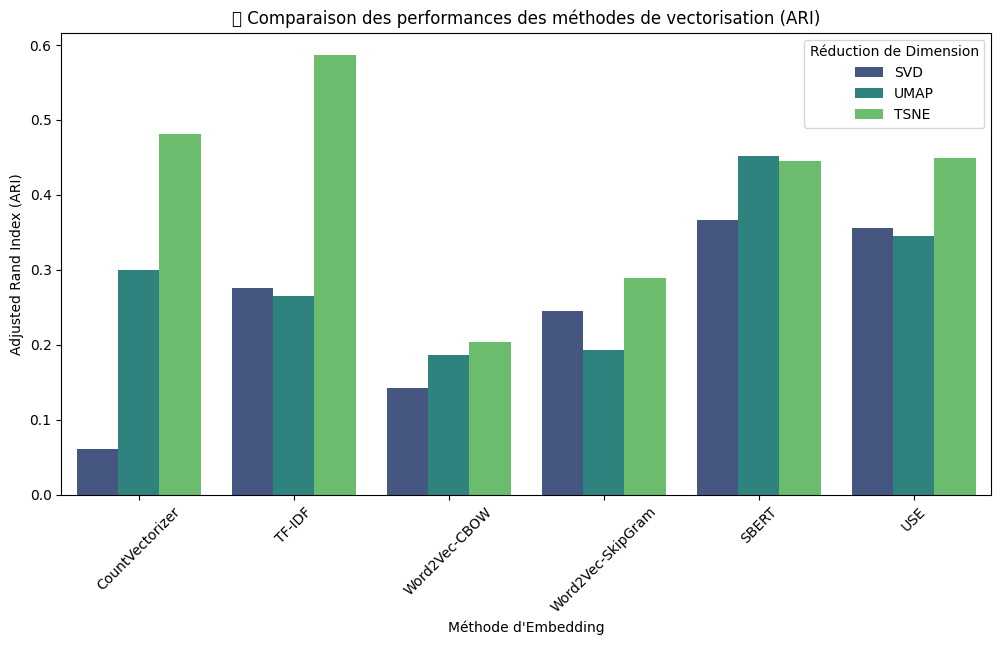

In [199]:
# 📌 Extraction uniquement des scores ARI
df_ari_results["ARI_score"] = df_ari_results["ARI"].apply(lambda x: x[0])  # Extraire uniquement le score ARI

# 📌 Visualisation des scores ARI
plt.figure(figsize=(12, 6))
sns.barplot(data=df_ari_results, x="Modèle", y="ARI_score", hue="Réduction", palette="viridis")

plt.ylabel("Adjusted Rand Index (ARI)")
plt.xlabel("Méthode d'Embedding")
plt.title("📊 Comparaison des performances des méthodes de vectorisation (ARI)")
plt.xticks(rotation=45)
plt.legend(title="Réduction de Dimension")

plt.show()

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


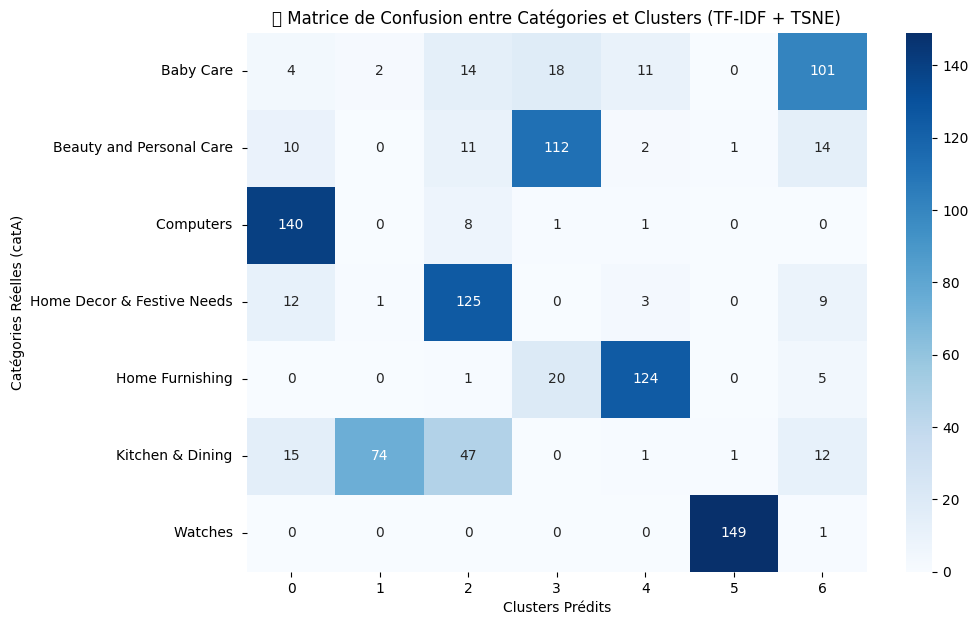

In [202]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import LabelEncoder

# Vectorisation avec TF-IDF
vectorizer_tfidf = TfidfVectorizer(stop_words="english", min_df=0.01, max_df=0.95)
tfidf_features = vectorizer_tfidf.fit_transform(data["cleaned_description"])

# Réduction de dimension avec TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tfidf_reduced_tsne = tsne.fit_transform(tfidf_features.toarray())

# Clustering avec KMeans
nb_clusters = len(data["catA"].unique())  # Nombre de catégories uniques
kmeans = KMeans(n_clusters=nb_clusters, random_state=42, n_init=10)
predicted_clusters = kmeans.fit_predict(tfidf_reduced_tsne)

#  Conversion des labels réels en entiers
label_encoder = LabelEncoder()
true_labels_numeric = label_encoder.fit_transform(data["catA"])  # Convertit les catégories en nombres

# Création de la Matrice de Confusion
conf_matrix = confusion_matrix(true_labels_numeric, predicted_clusters)

# Affichage de la Matrice de Confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(predicted_clusters), 
            yticklabels=label_encoder.classes_)  # Affichage des noms de catégories réelles

plt.xlabel("Clusters Prédits")
plt.ylabel("Catégories Réelles (catA)")
plt.title("📊 Matrice de Confusion entre Catégories et Clusters (TF-IDF + TSNE)")
plt.show()